# Flexspace Customer Analysis

## Introduction

Flexspace is an on-demand workspace platform that gives companies access to real-time co-working space availability that employees can book right from their calendars. Their goal is to provide customers with the flexibility and space their employees need to thrive, and to help co-working partners easily monetize their unused perishable workspaces.

The goal of the overall analysis is to primarily focus on two groups in the data: *Operators and Customers*. This notebook will cover a Customer analysis to answer the following business questions:

- Using an RFM analysis, who are our 'high value' customers? What makes them high value?
    - Which customers are providing more business? Who is more engaged? Why? 
- For returning customers (who ordered more than once with Flexspace): Why did they return? 
    - What made the product "sticky?" Discount received? Promotion received? Geographic? Product type?
- How can we get new customers to become returning customers?

In [1]:
!pip install psycopg2-binary

In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import engine
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [3]:
# First, I will connect to the data and create a dataframe

conn_string = r"postgresql://masterschool-analyst:pa84cc0d01e9b241460abdf838bb34f5932c9473dca571b56fcb13dd3023a62e0@ec2-52-4-84-108.compute-1.amazonaws.com:5432/da541q56oobji4"
connection = engine.create_engine(conn_string)

In [5]:
query = """select * from mat_orders"""

df = pd.read_sql(query, con=conn_string)

In [6]:
df.shape

(42403, 49)

In [7]:
# I will save the original view as a CSV to have as a backup. When the notebook runs, the CSV will be updated

df.to_csv(r'C:\Users\nguzm\OneDrive\Desktop\Data Studio\flexspace_original.csv')

## Filtering the Relevant Data

### Disclaimers
During initial exploration, the following parameters were established:

- Only look at values with the status "paid"  

- "total_price_in_usd" is the value of that order transacted through Flexspace  

- Only consider orders with the source WL or FM: The source indicates the client apps the order was made from. In the context of Flexspace Commerce, only WL and FM sources will be considered
- Exclude test users: We will ignore any full name, company name, and email containing the word "test"
- There is also a promotion code BETEST - please advise about that and other tests that we can identify ahead
- If it's a test, the value "total_price_in_usd" is usually zero (no money transacted), or the order is canceled (and refunded) with "status" as "canceled".
- Exclude/ignore taxes: this is usually transparent and we do not need to look into it
- When looking at prices consider the original price (total_price+discount), discount (in usd), and the final price (total_price)
- These fields ds_organization_id, ds_budget_id, and auth0_user_id are not related in the context of Flexspace eCommerce and can be excluded.
- Operators can be found in “partner_name”
- Customers are defined by their email as a “primary key”


In [9]:
# I will transfer the query used to create the filtered CTE in SQL here to create a subset of the relevant data for analysis.
# I will have to use %% for my ilike conditions since % is used by Python string formatting

cte_query = """
  SELECT 
    order_id, 
    partner_id AS operator_id, 
    partner_name AS operator_name, 
    status, 
    m.source, 
    fullname, 
    email AS customer_email, 
    company_name, 
    confirmation_id, 
    space_id, 
    space_name, 
    created_at, 
    promotion_code, 
    total_price AS final_price, 
    --not usd,  sub_total + tax_amount, sub_total=order_line_item_total_price
    ABS(discounted_amount) AS discounted_amount, 
    --not usd
    total_price_in_usd AS final_price_usd, 
    --amount transacted through Flexspace
    ABS(ROUND(
      discounted_amount * to_usd_rate, 2
    )) AS discounted_amount_usd, 
    ROUND(
      (
        total_price_in_usd + ABS(discounted_amount * to_usd_rate)
      ), 
      2
    ) AS original_price_usd, 
    processing_fee_in_usd, 
    to_usd_rate, 
    location_id, 
    location_name_en, 
    location_time_zone, 
    country, 
    m.state, 
    city, 
    order_line_item_id, 
    orderable_type, 
    orderable_id, 
    order_line_item_details, 
    access_id, 
    booking_product_type, 
    product_type_id, 
    add_on_days_to_expire, 
    capacity, 
    booking_id, 
    start_date, 
    end_date, 
    date, 
    quantity, 
    last_refresh 
  FROM 
    mat_orders AS m 
  WHERE 
    status = 'paid' 
    AND email NOT IN (
      SELECT 
        email 
      FROM 
        mat_orders 
      WHERE 
        1 = 1 
        AND (
          company_name ILIKE '%%test%%'
          OR fullname ILIKE '%%test%%' 
          OR email ILIKE '%%test%%' 
          OR promotion_code ILIKE '%%test%%'
          OR partner_name ILIKE '%%test%%'
        )
    ) 
    AND m.source IN ('WL', 'FM')
;

"""

filtered_df = pd.read_sql(cte_query, con=conn_string)

In [10]:
# I want to check the filtered result here to ensure the expected filtered result is produced.
# Condition status = ‘paid’ removed 17644+ rows
# Condition to exclude test users removed 273+ rows
# Condition m.source IN (‘WL’, ‘FM’) removed 945+ rows

filtered_df.shape

(23529, 41)

In [11]:
# I will also save the filtered data locally for safe keeping

df.to_csv(r'C:\Users\nguzm\OneDrive\Desktop\Data Studio\flexspace_filtered.csv')

## Sanity Checks

This section will be dedicated to performing checks on the data in order to find and address any further issues if necessary.

I will check:

- Data types of the columns in the filtered_df
- The range of time the data exists (earliest date)
- Are there any duplicate order_id's (this should be the primary key for the data)?
- General statistics for any unusual values


**Number of Unique Customers**

In [12]:
filtered_df.customer_email.nunique()

14519

In [14]:
pd.set_option('display.max_columns', None)

filtered_df.head()

,order_id,operator_id,operator_name,status,source,fullname,customer_email,company_name,confirmation_id,space_id,space_name,created_at,promotion_code,final_price,discounted_amount,final_price_usd,discounted_amount_usd,original_price_usd,processing_fee_in_usd,to_usd_rate,location_id,location_name_en,location_time_zone,country,state,city,order_line_item_id,orderable_type,orderable_id,order_line_item_details,access_id,booking_product_type,product_type_id,add_on_days_to_expire,capacity,booking_id,start_date,end_date,date,quantity,last_refresh
0,40af10f9-9150-4a7b-bb72-a52a031d73dd,b6bfa6e9-e780-4b7c-af83-39a63380a709,WeWork Israel,paid,WL,Yehoshua King,yehoshuaking@gmail.com,YK,ba25e6fa,0f197ecc-570f-4bed-b382-9a2b717ce533,Open Workspace Day Pass,2023-05-22 09:44:09.758168,None,128.70,0.0,35.24,0.00,35.24,0.00,0.273802,b2ee7ec8-5c3d-4768-9c47-64fd57d79cc7,WeWork Jerusalem,Asia/Jerusalem,IL,None,Jerusalem,65acd600-8c75-47f1-868a-9b57f5b042fe,Booking,fde13c1b-50b0-4d61-acfc-51cd7e4e2662,"{'days': 1, 'end_date': '2023-05-22', 'quantit...",None,entire_location,3ab24bff-a8c0-4773-8c12-81f2d9978f93,NaN,1.0,fde13c1b-50b0-4d61-acfc-51cd7e4e2662,2023-05-22,2023-05-22,None,1.0,2023-07-17 14:45:18.109205+00:00
1,041cac62-1867-453e-a5ea-5d80a54ab149,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Segah Meer,segah@keetro.net,Keetro Labs,754008a9,62e8d0bd-d025-485a-a836-02adf6d32ccd,Mindspace Daily - Ha’Bursa,2021-06-02 05:20:12.325725,SPECIAL521,1067.04,48.0,325.97,14.66,340.63,9.75,0.305490,aae68b56-d19a-4b68-a795-1047ca8748a2,Ramat Gan - Ha’Bursa,Asia/Jerusalem,IL,None,Ramat Gan,359640c3-fa2b-4210-8254-dd67955f9ab5,AddOn,3a05162a-c2c2-47fd-91d0-b1ac10d43144,{'space_id': '62e8d0bd-d025-485a-a836-02adf6d3...,None,access_add_on,1986c53d-96a1-4394-8012-a993b46f6e43,60.0,NaN,None,None,None,None,1.0,2023-07-17 14:45:18.109205+00:00
2,c437542e-7369-4f57-9634-d3d8c906049d,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Mark Bosshard,mark.bosshard1@gmail.com,ipt,163b482a,eb3f2ab3-a890-452e-aae9-099e49454f2f,Mindspace Daily - Dam,2021-11-26 08:11:23.629412,None,30.25,0.0,33.57,0.00,33.57,1.61,1.109830,76fdc9f9-777d-401b-bf05-f1f81c27933a,Amsterdam - Dam,Europe/Amsterdam,NL,None,Amsterdam,afc68bc2-cba4-4229-aa52-eff96dffee1b,Booking,1c23a107-65a9-453a-8367-5e7d81b6f772,"{'days': 1, 'time': None, 'end_date': '2021-11...",None,entire_location,bef677a6-5596-4ca0-a31e-ea2eccb5e959,NaN,1.0,1c23a107-65a9-453a-8367-5e7d81b6f772,2021-11-26,2021-11-26,None,1.0,2023-07-17 14:45:18.109205+00:00
3,9906ceef-5ac6-411c-ac3f-bdc88494f7fd,b6bfa6e9-e780-4b7c-af83-39a63380a709,WeWork Israel,paid,WL,Justin Rohloff,justin@rohloffgroup.co.za,Rohloff,6abd5552,0f197ecc-570f-4bed-b382-9a2b717ce533,Open Workspace Day Pass,2021-11-15 07:18:18.568518,None,374.40,0.0,120.69,0.00,120.69,0.00,0.322369,b2ee7ec8-5c3d-4768-9c47-64fd57d79cc7,WeWork Jerusalem,Asia/Jerusalem,IL,None,Jerusalem,ca946768-159d-41b6-9cd6-c2d9440f7c72,AddOn,afd158c3-900d-482b-b91f-193b25e7963a,{'space_id': '0f197ecc-570f-4bed-b382-9a2b717c...,None,access_add_on,e1b38119-616d-4a17-8dd0-3458369ca4e8,90.0,NaN,None,None,None,None,1.0,2023-07-17 14:45:18.109205+00:00
4,f2da7ed7-00cd-4d85-85b3-a5121fd28202,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Andrei Marcut,andrei@creativegluelab.com,Creative Glue Lab GmbH,4e5e9d5c,138b7e56-61c1-4e9a-9a56-84bae539f131,Mindspace Daily - Uhlandstraße 32 (Ku'damm),2023-04-11 07:40:12.034568,,104.72,0.0,112.69,0.00,112.69,4.69,1.076110,855fa3e4-8382-4fbc-b2f9-d9b0f9a20f57,Berlin - Ku’damm,Europe/Berlin,DE,None,Berlin,a0a9fbae-2575-4e73-b7d6-ec923ad8bfff,AddOn,d2adbe4e-aa1e-484e-af40-60f3fe3abfa8,{'space_id': '138b7e56-61c1-4e9a-9a56-84bae539...,None,access_add_on,1986c53d-96a1-4394-8012-a993b46f6e43,30.0,NaN,None,None,None,None,1.0,2023-07-17 14:45:18.109205+00:00


**Checking Data Types**

In [15]:
# Are the data types appropriate?

filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23529 entries, 0 to 23528
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   order_id                 23529 non-null  object             
 1   operator_id              23529 non-null  object             
 2   operator_name            23529 non-null  object             
 3   status                   23529 non-null  object             
 4   source                   23529 non-null  object             
 5   fullname                 23529 non-null  object             
 6   customer_email           23529 non-null  object             
 7   company_name             23529 non-null  object             
 8   confirmation_id          23529 non-null  object             
 9   space_id                 23522 non-null  object             
 10  space_name               23522 non-null  object             
 11  created_at               235

*The data types are appropriate for now. Changes will be made if needed.*

In [16]:
# access_id can be dropped since this only contains null values

filtered_df = filtered_df.drop(['access_id'], axis=1)

filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23529 entries, 0 to 23528
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   order_id                 23529 non-null  object             
 1   operator_id              23529 non-null  object             
 2   operator_name            23529 non-null  object             
 3   status                   23529 non-null  object             
 4   source                   23529 non-null  object             
 5   fullname                 23529 non-null  object             
 6   customer_email           23529 non-null  object             
 7   company_name             23529 non-null  object             
 8   confirmation_id          23529 non-null  object             
 9   space_id                 23522 non-null  object             
 10  space_name               23522 non-null  object             
 11  created_at               235

**Date Range for Data**

In [17]:
# What is the earliest date in the filtered_df?

filtered_df.created_at.min()

Timestamp('2021-03-10 08:15:57.441884')

**The earliest date is Mar. 3, 2021 meaning the data spans over approx 2 years. Since 2022 is the most recent full year in the data, that will be taken into consideration.**

**Checking for Duplicates**

In [18]:
# Are there any duplicate customers?

duplicate_rows = filtered_df[filtered_df['order_id'].duplicated(keep=False)]
print(duplicate_rows)


Empty DataFrame
Columns: [order_id, operator_id, operator_name, status, source, fullname, customer_email, company_name, confirmation_id, space_id, space_name, created_at, promotion_code, final_price, discounted_amount, final_price_usd, discounted_amount_usd, original_price_usd, processing_fee_in_usd, to_usd_rate, location_id, location_name_en, location_time_zone, country, state, city, order_line_item_id, orderable_type, orderable_id, order_line_item_details, booking_product_type, product_type_id, add_on_days_to_expire, capacity, booking_id, start_date, end_date, date, quantity, last_refresh]
Index: []


*Customers can make more than one order, and each row in the filtered_df is an order. There are no duplicate orders*

**General Summary Statistics**

In [20]:
# What are some general statistics for the monetary values in filtered_df?

filtered_df.describe()

,final_price,discounted_amount,final_price_usd,discounted_amount_usd,original_price_usd,processing_fee_in_usd,to_usd_rate,add_on_days_to_expire,capacity,quantity
count,23529.000000,23529.000000,23529.000000,23529.000000,23529.000000,23529.000000,23529.000000,3043.000000,20458.000000,23522.000000
mean,199.751054,9.773083,105.433248,4.903183,110.336431,2.829245,0.831001,48.149852,2.945009,1.183148
std,365.346613,70.999662,149.950461,31.211178,159.024153,4.308370,0.353169,23.856723,25.414539,0.696215
min,0.640000,0.000000,0.680000,0.000000,13.690000,0.000000,0.198240,30.000000,1.000000,1.000000
25%,35.000000,0.000000,34.830000,0.000000,35.000000,1.170000,0.306788,30.000000,1.000000,1.000000
50%,71.400000,0.000000,47.890000,0.000000,49.570000,1.610000,1.000000,30.000000,1.000000,1.000000
75%,175.500000,0.000000,118.250000,0.000000,120.140000,3.030000,1.042690,60.000000,1.000000,1.000000
max,9009.000000,3715.000000,3125.000000,1057.510000,3200.000000,116.300000,1.405630,180.000000,1000.000000,20.000000


**Initial Considerations and Observations**

The **discounted_amount_usd, original_price_usd, and final_price_usd** have large maximum values. Could this be tied to orders/spaces with higher capacities? Higher discounts or promotion codes received? What products did they purchase? Did those belong to returning customers? And if so, was there something that made them spend more? I will keep that in mind as I analyze returning customer behavior. With discounts, it is likely the majority of orders/customers did not receive a discount. It will be worth looking into the distributions for these columns.

## General Customer Overview

This section will be dedicated to finding some general insights about the Flexspace customers. The following questions will be addressed and visualized if needed:

- How many distinct customers are there? Per company?
- Where are customers located? 
- What orderable_types and booking_product_types are customers ordering? What are the total order distribution counts for each type?
- What is the product basket customers are purchasing? What programmatic combinations of products are being ordered by customers?
- What is the distribution of the monetary columns? Are there any outliers, or are these purchases specific to a customer or group, space, etc?


#### How many distinct customers are there?


In [21]:
# How many distinct customers are there? 

filtered_df.customer_email.nunique()

14519

#### Number of customers per company?

In [22]:
# How many distinct customers per company?
# Could do distribution of customers with count of companies per bin

customer_company = filtered_df[['company_name', 'customer_email']].groupby('company_name').nunique('customer_email').sort_values('customer_email', ascending=False)

customer_company = customer_company.reset_index()

#filtered_df.company_name.nunique()

customer_company.head(20)

,company_name,customer_email
0,N/A,201
1,-,106
2,Self,103
3,NA,100
4,n/a,63
5,None,54
6,Na,38
7,N/a,33
8,Private,27
9,Personal,27


**With this many companies, it may get complicated to show the count of customers from each one. Additionally, I can see that company_name has some issues regarding the values having multiple variations (self, Self, Self-employed). These will need to be cleaned to ensure consistency in company_name. There were also some values that were in other languages. These should be considered when cleaning.**

In [23]:
# I will initially clean the values by making them consitent cases

filtered_df['company_name_lower'] = filtered_df['company_name'].str.lower()

In [24]:
# Filter the groups with only one distinct 'customer_email'
company_one_customer = customer_company[customer_company['customer_email'] == 1]

# Get the company names with only one distinct customer email
# company_names = filtered['company_name']

# Display the company names
print(company_one_customer)


                             company_name  customer_email
1383                            Swipecast               1
1384                    Sanity Group GmbH               1
1385                     So Nessasary llc               1
1386   Sustainable Fisheries Partnership                1
1387                          Sapiens LLC               1
...                                   ...             ...
13465                        Ihar Akhunau               1
13466                          Ihar Yasko               1
13467                               Ikatz               1
13468                          Ilan Keren               1
13469                     ℅ Emily Barasch               1

[12087 rows x 2 columns]


**The majority of companies only have 1 customer. This could be due to the company being private, perhaps only one representative of the company being the sole user of Flexspace for a group. I will need to ensure further cleaning is done. It is likely that a private user is ordering spaces with a capacity of 1 or some small value.**

In [25]:
# Replace the similar values with 'self-employed' and 'n/a'
# Define the pattern replacements
pattern_replacements = {
    r'.*self.*': 'self-employed',
    r'(?<!\bsourceability \b)\bna\b': 'n/a',
    r'^-$': 'n/a',
    r'(?<!\bbar \b)\bnone\b': 'n/a',
    r'^ $': 'n/a',
    r'^  $': 'n/a'
}

for pattern, replacement in pattern_replacements.items():
    filtered_df['company_name_lower'] = filtered_df['company_name_lower'].str.replace(pattern, replacement, regex=True)

# Value counts on company_name_lower
filtered_df.company_name_lower.value_counts().head(20)

n/a                        796
self-employed              250
knowledge train             86
augury                      78
ciic pr                     60
videoamp                    53
sharethis                   49
seed                        45
hardskills gmbh             42
synerflow b.v.              42
lookiero style uk ltd       42
razroo ltd                  41
opportunity lab             41
ביי וויט בע״מ               40
private                     39
studio werc ltd             39
beeremote inc.              37
grafana labs                36
digital republic talent     36
personal                    34
Name: company_name_lower, dtype: int64

In [28]:
#How did this affect the distribution?

customer_company = filtered_df[['company_name_lower', 'customer_email']].groupby('company_name_lower').nunique('customer_email').sort_values('customer_email', ascending=False).reset_index()

customer_company.head(20)

,company_name_lower,customer_email
0,n/a,607
1,self-employed,183
2,private,34
3,personal,30
4,modern health,25
5,freelance,22
6,gitlab,18
7,shopify,17
8,,16
9,sharethis,15


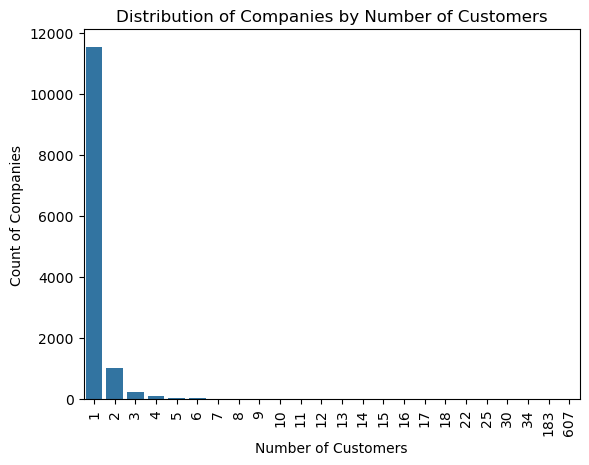

In [30]:
#create a variable for the seaborn color argument
plot_color = sns.color_palette()[0]

sns.countplot(data = customer_company, x = 'customer_email', color = plot_color).set(title='Distribution of Companies by Number of Customers', xlabel = 'Number of Customers', ylabel= 'Count of Companies');
plt.xticks(rotation=90)
plt.show()

#### The cleaning so far affected the order frequency per company since several were consolidated, but not sure if this has a huge affect on customer distribution. I will stop this exploration of companies for now and instead consider grouping customers by email domain if needed.

#### Where are customers located?

In [31]:
# Where are customers located?

# How many countries are in the filtered data, and what frequency of orders does each have? 
#Order frequency per country
filtered_df.country.value_counts()


US    9386
IL    6106
DE    4951
GB    1237
NL     963
PL     587
RO     292
Name: country, dtype: int64

In [32]:
# Are there any null values in 'country'?

filtered_df.country.isna().sum()

7

There are only 7 nulls in the country column, and these should not affect our results.

**There are 7 countries in the filtered data:**

1. US (United States)
2. IL (Israel)
3. DE (Germany)
4. GB (Great Britain/United Kingdom)
5. NL (Netherlands)
6. PL (Poland)
7. RO (Romania)

**5 countries were excluded from the original data. This could be due to low order frequencies:**

1. AU (Australia)
2. CA (Canada)
3. MX (Mexico)
4. PT (Portugal)
5. VN (Vietnam)

It could be helpful to inlcude the full names for each country for readability. 

In [33]:
# Mapping dictionary for country codes to country names
country_mapping = {'US': 'United States', 
                   'GB': 'United Kingdom', 
                   'IL': 'Israel', 
                   'NL': 'Netherlands', 
                   'PL':'Poland', 
                   'RO':'Romania',
                   'DE':'Germany'
                  }

# Create a new column with the full country names
filtered_df['country_full'] = filtered_df['country'].map(country_mapping)

# Display the DataFrame
filtered_df.head()

,order_id,operator_id,operator_name,status,source,fullname,customer_email,company_name,confirmation_id,space_id,space_name,created_at,promotion_code,final_price,discounted_amount,final_price_usd,discounted_amount_usd,original_price_usd,processing_fee_in_usd,to_usd_rate,location_id,location_name_en,location_time_zone,country,state,city,order_line_item_id,orderable_type,orderable_id,order_line_item_details,booking_product_type,product_type_id,add_on_days_to_expire,capacity,booking_id,start_date,end_date,date,quantity,last_refresh,company_name_lower,country_full
0,40af10f9-9150-4a7b-bb72-a52a031d73dd,b6bfa6e9-e780-4b7c-af83-39a63380a709,WeWork Israel,paid,WL,Yehoshua King,yehoshuaking@gmail.com,YK,ba25e6fa,0f197ecc-570f-4bed-b382-9a2b717ce533,Open Workspace Day Pass,2023-05-22 09:44:09.758168,None,128.70,0.0,35.24,0.00,35.24,0.00,0.273802,b2ee7ec8-5c3d-4768-9c47-64fd57d79cc7,WeWork Jerusalem,Asia/Jerusalem,IL,None,Jerusalem,65acd600-8c75-47f1-868a-9b57f5b042fe,Booking,fde13c1b-50b0-4d61-acfc-51cd7e4e2662,"{'days': 1, 'end_date': '2023-05-22', 'quantit...",entire_location,3ab24bff-a8c0-4773-8c12-81f2d9978f93,NaN,1.0,fde13c1b-50b0-4d61-acfc-51cd7e4e2662,2023-05-22,2023-05-22,None,1.0,2023-07-17 14:45:18.109205+00:00,yk,Israel
1,041cac62-1867-453e-a5ea-5d80a54ab149,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Segah Meer,segah@keetro.net,Keetro Labs,754008a9,62e8d0bd-d025-485a-a836-02adf6d32ccd,Mindspace Daily - Ha’Bursa,2021-06-02 05:20:12.325725,SPECIAL521,1067.04,48.0,325.97,14.66,340.63,9.75,0.305490,aae68b56-d19a-4b68-a795-1047ca8748a2,Ramat Gan - Ha’Bursa,Asia/Jerusalem,IL,None,Ramat Gan,359640c3-fa2b-4210-8254-dd67955f9ab5,AddOn,3a05162a-c2c2-47fd-91d0-b1ac10d43144,{'space_id': '62e8d0bd-d025-485a-a836-02adf6d3...,access_add_on,1986c53d-96a1-4394-8012-a993b46f6e43,60.0,NaN,None,None,None,None,1.0,2023-07-17 14:45:18.109205+00:00,keetro labs,Israel
2,c437542e-7369-4f57-9634-d3d8c906049d,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Mark Bosshard,mark.bosshard1@gmail.com,ipt,163b482a,eb3f2ab3-a890-452e-aae9-099e49454f2f,Mindspace Daily - Dam,2021-11-26 08:11:23.629412,None,30.25,0.0,33.57,0.00,33.57,1.61,1.109830,76fdc9f9-777d-401b-bf05-f1f81c27933a,Amsterdam - Dam,Europe/Amsterdam,NL,None,Amsterdam,afc68bc2-cba4-4229-aa52-eff96dffee1b,Booking,1c23a107-65a9-453a-8367-5e7d81b6f772,"{'days': 1, 'time': None, 'end_date': '2021-11...",entire_location,bef677a6-5596-4ca0-a31e-ea2eccb5e959,NaN,1.0,1c23a107-65a9-453a-8367-5e7d81b6f772,2021-11-26,2021-11-26,None,1.0,2023-07-17 14:45:18.109205+00:00,ipt,Netherlands
3,9906ceef-5ac6-411c-ac3f-bdc88494f7fd,b6bfa6e9-e780-4b7c-af83-39a63380a709,WeWork Israel,paid,WL,Justin Rohloff,justin@rohloffgroup.co.za,Rohloff,6abd5552,0f197ecc-570f-4bed-b382-9a2b717ce533,Open Workspace Day Pass,2021-11-15 07:18:18.568518,None,374.40,0.0,120.69,0.00,120.69,0.00,0.322369,b2ee7ec8-5c3d-4768-9c47-64fd57d79cc7,WeWork Jerusalem,Asia/Jerusalem,IL,None,Jerusalem,ca946768-159d-41b6-9cd6-c2d9440f7c72,AddOn,afd158c3-900d-482b-b91f-193b25e7963a,{'space_id': '0f197ecc-570f-4bed-b382-9a2b717c...,access_add_on,e1b38119-616d-4a17-8dd0-3458369ca4e8,90.0,NaN,None,None,None,None,1.0,2023-07-17 14:45:18.109205+00:00,rohloff,Israel
4,f2da7ed7-00cd-4d85-85b3-a5121fd28202,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Andrei Marcut,andrei@creativegluelab.com,Creative Glue Lab GmbH,4e5e9d5c,138b7e56-61c1-4e9a-9a56-84bae539f131,Mindspace Daily - Uhlandstraße 32 (Ku'damm),2023-04-11 07:40:12.034568,,104.72,0.0,112.69,0.00,112.69,4.69,1.076110,855fa3e4-8382-4fbc-b2f9-d9b0f9a20f57,Berlin - Ku’damm,Europe/Berlin,DE,None,Berlin,a0a9fbae-2575-4e73-b7d6-ec923ad8bfff,AddOn,d2adbe4e-aa1e-484e-af40-60f3fe3abfa8,{'space_id': '138b7e56-61c1-4e9a-9a56-84bae539...,access_add_on,1986c53d-96a1-4394-8012-a993b46f6e43,30.0,NaN,None,None,None,None,1.0,2023-07-17 14:45:18.109205+00:00,creative glue lab gmbh,Germany


In [34]:
# Visualize the number of customers in each of the 7 countries

customer_country = filtered_df[['country_full', 'customer_email']].groupby('country_full').nunique('customer_email').sort_values('customer_email', ascending=False)

customer_country = customer_country.reset_index()

customer_country

,country_full,customer_email
0,United States,6343
1,Israel,3387
2,Germany,2991
3,Netherlands,686
4,United Kingdom,544
5,Poland,420
6,Romania,186


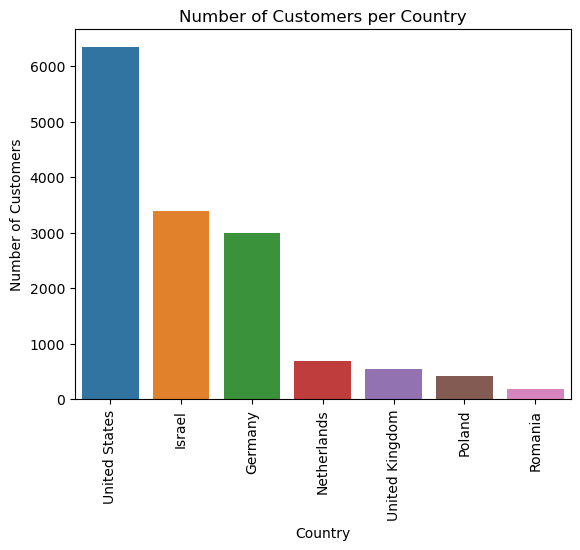

In [35]:
sns.barplot(data = customer_country, x = 'country_full', y = 'customer_email').set(title='Number of Customers per Country', xlabel='Country', ylabel='Number of Customers')
plt.xticks(rotation = 90)
plt.show;

**The majority of customers are in the United States with approximately half that amount of customers in Israel, the second ranked country by number of customers. This will be important to keep in mind to later get an idea of where the high value and returning customers mostly reside.**

#### What orderable_types and booking_product_types are customers ordering? What are the total order distribution counts for each type?

In [41]:
order_booking_types = filtered_df.groupby(['orderable_type', 'booking_product_type'])['order_id'].count().reset_index()

order_booking_types.sort_values('order_id', ascending=False, ignore_index=True)

,orderable_type,booking_product_type,order_id
0,Booking,entire_location,15904
1,Booking,meeting_room,3220
2,AddOn,access_add_on,3043
3,Booking,private_office,1334
4,AddOn,add_on,21


**I want to see the avg capacities for these, and then the distribution of capacities per product_type to get a better understanding of what is available to the customer.**

In [44]:
#Product and avg capacity

product_capacity = filtered_df[['orderable_type', 'booking_product_type', 'order_id', 'customer_email', 'capacity']].groupby(['orderable_type', 'booking_product_type']).agg({'order_id':'nunique', 
                                                                                                                                                                            'customer_email':'nunique',
                                                                                                                                                                            'capacity':'mean'}).reset_index()

product_capacity.sort_values('order_id', ascending=False, ignore_index=True)

,orderable_type,booking_product_type,order_id,customer_email,capacity
0,Booking,entire_location,15904,10828,1.000000
1,Booking,meeting_room,3220,1940,8.467702
2,AddOn,access_add_on,3043,1917,NaN
3,Booking,private_office,1334,786,12.802849
4,AddOn,add_on,21,18,NaN


**From this initial look at capacity, it seems like entire_location more often is meant for 1 person to use since the average capacity is 1. This was also seen when describe was used to get summary statistics. These labels are initially misleading because 'entire_location' seems to be a 1 person capacity, while 'private_office' has a much higher average. Though I will stop my investigation of capacity here as this metric is not relevant to the business questions.**

#### What is the product basket customers are purchasing? What programmatic combinations of products are being ordered by customers?

In [92]:
#Without considering programmatic combinations, below is a SQL query that shows products each customer has purchased

product_basket_query = """
WITH mat_orders_CTE AS (
  SELECT 
    order_id, 
    partner_id AS operator_id, 
    partner_name AS operator_name, 
    status, 
    m.source, 
    fullname, 
    email AS customer_email, 
    company_name, 
    confirmation_id, 
    space_id, 
    space_name, 
    created_at, 
    promotion_code, 
    total_price AS final_price, 
    --not usd,  sub_total + tax_amount, sub_total=order_line_item_total_price
    ABS(discounted_amount) AS discounted_amount, 
    --not usd
    total_price_in_usd AS final_price_usd, 
    --amount transacted through Flexspace
    ABS(ROUND(
      discounted_amount * to_usd_rate, 2
    )) AS discounted_amount_usd, 
    ROUND(
      (
        total_price_in_usd + ABS(discounted_amount * to_usd_rate)
      ), 
      2
    ) AS original_price_usd, 
    processing_fee_in_usd, 
    to_usd_rate, 
    location_id, 
    location_name_en, 
    location_time_zone, 
    country, 
    m.state, 
    city, 
    order_line_item_id, 
    orderable_type, 
    orderable_id, 
    order_line_item_details, 
    access_id, 
    booking_product_type, 
    product_type_id, 
    add_on_days_to_expire, 
    capacity, 
    booking_id, 
    start_date, 
    end_date, 
    date, 
    quantity, 
    last_refresh 
  FROM 
    mat_orders AS m 
  WHERE 
    status = 'paid' 
    AND email NOT IN (
      SELECT 
        email 
      FROM 
        mat_orders 
      WHERE 
        1 = 1 
        AND (
          company_name ILIKE '%%test%%'
          OR fullname ILIKE '%%test%%' 
          OR email ILIKE '%%test%%' 
          OR company_name ILIKE '%%test%%' 
          OR promotion_code ILIKE '%%test%%'
        )
    ) 
    AND m.source IN ('WL', 'FM')
    )
,
customer_products AS (
 SELECT customer_email, 
 booking_product_type, 
 CASE WHEN booking_product_type = 'entire_location' THEN COUNT(*) ELSE 0 END AS num_entire_location,
 CASE WHEN booking_product_type = 'meeting_room' THEN COUNT(*) ELSE 0 END AS num_meeting_room,
 CASE WHEN booking_product_type = 'access_add_on' THEN COUNT(*) ELSE 0 END AS num_access_add_on,
 CASE WHEN booking_product_type = 'private_office' THEN COUNT(*) ELSE 0 END AS num_private_office,
 CASE WHEN booking_product_type = 'add_on' THEN COUNT(*) ELSE 0 END AS num_add_on,
 COUNT(DISTINCT order_id) AS num_orders
 FROM mat_orders_CTE AS m
 GROUP BY 1, 2
 )
 ,

 product_basket AS (

 SELECT customer_email, 
 	STRING_AGG(DISTINCT booking_product_type, ', ') AS product_type_ordered,
 	COUNT(booking_product_type) AS num_product_type,
 	SUM(num_entire_location) AS total_entire_location,
 	SUM(num_meeting_room) AS total_meeting_room,
 	SUM(num_access_add_on) AS total_access_add_on,
 	SUM(num_private_office) AS total_private_office,
    SUM(num_add_on) AS total_add_on,
 	SUM(num_orders) AS total_orders
 FROM customer_products AS c
 GROUP BY 1
 ORDER BY 9 DESC)

 SELECT *
 FROM product_basket;"""

product_basket = pd.read_sql(product_basket_query, con=conn_string)

product_basket

,customer_email,product_type_ordered,num_product_type,total_entire_location,total_meeting_room,total_access_add_on,total_private_office,total_add_on,total_orders
0,sgrossman@augury.com,"entire_location, meeting_room, private_office",3,7.0,69.0,0.0,2.0,0.0,80.0
1,ohr@buywith.com,"entire_location, meeting_room, private_office",3,6.0,3.0,0.0,33.0,0.0,42.0
2,gabriel@beeremote.co,"entire_location, meeting_room",2,34.0,8.0,0.0,0.0,0.0,42.0
3,charlie@razroo.com,"entire_location, private_office",2,3.0,0.0,0.0,39.0,0.0,42.0
4,rob@studiowerc.com,entire_location,1,41.0,0.0,0.0,0.0,0.0,41.0
...,...,...,...,...,...,...,...,...,...
14522,georgiylukjanov@gmail.com,access_add_on,1,0.0,0.0,1.0,0.0,0.0,1.0
14523,georg@thespacebetween.at,entire_location,1,1.0,0.0,0.0,0.0,0.0,1.0
14524,georg.wolf@me.com,entire_location,1,1.0,0.0,0.0,0.0,0.0,1.0
14525,geostik@gmail.com,access_add_on,1,0.0,0.0,1.0,0.0,0.0,1.0


In [93]:
#Number of customers who ordered each product combination

product_basket.product_type_ordered.value_counts()


entire_location                                                 9998
meeting_room                                                    1706
access_add_on                                                   1281
private_office                                                   619
access_add_on, entire_location                                   549
entire_location, meeting_room                                    131
entire_location, private_office                                   91
meeting_room, private_office                                      33
access_add_on, entire_location, meeting_room                      31
access_add_on, meeting_room                                       23
access_add_on, private_office                                     16
access_add_on, entire_location, private_office                    15
entire_location, meeting_room, private_office                     12
add_on                                                            12
add_on, entire_location           

**I want to see the top 5 products and how they sold over the course of the most recent year in the data (2022).**

In [94]:
filtered_df['date'] = filtered_df['created_at'].dt.date
filtered_df['date'] = pd.to_datetime(filtered_df['date'])

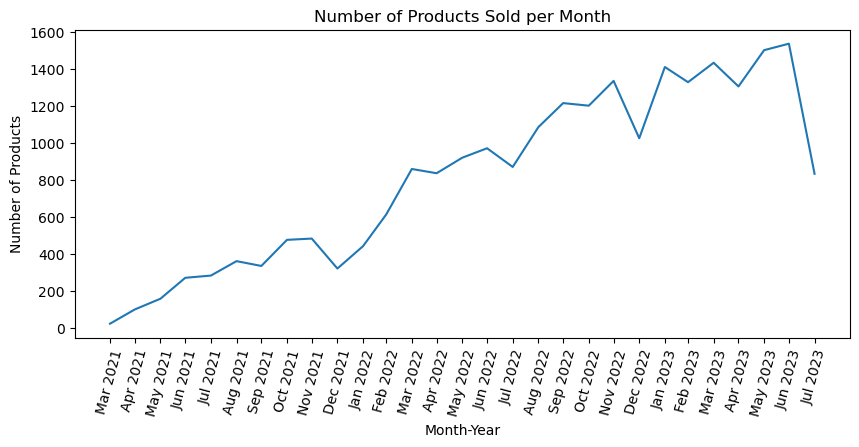

In [95]:
#First I want to see the general products sold over time

prod_over_time_df = pd.DataFrame(filtered_df.resample('M', on='date')['order_id'].count())
prod_over_time_df.columns = ['number_of_products_sold']
    
# plot prod_over_time_df
plt.figure(figsize=(10, 4))
sns.lineplot(x=prod_over_time_df.index, y=prod_over_time_df['number_of_products_sold'], color = plot_color)

# Set the chart title and axis labels
plt.title('Number of Products Sold per Month')
plt.xlabel('Month-Year')
plt.ylabel('Number of Products')

plt.xticks(prod_over_time_df.index, prod_over_time_df.index.strftime('%b %Y'), rotation=75)
plt.show()

In [96]:
#top products by orders placed

top_prod = product_basket.groupby('product_type_ordered')['total_orders'].sum().reset_index()

top_prod.sort_values('total_orders', ascending=False, ignore_index=True)

,product_type_ordered,total_orders
0,entire_location,13827.0
1,meeting_room,2620.0
2,"access_add_on, entire_location",2376.0
3,access_add_on,1846.0
4,private_office,919.0
5,"entire_location, meeting_room",608.0
6,"entire_location, private_office",363.0
7,"entire_location, meeting_room, private_office",243.0
8,"access_add_on, entire_location, meeting_room",198.0
9,"access_add_on, entire_location, private_office",171.0


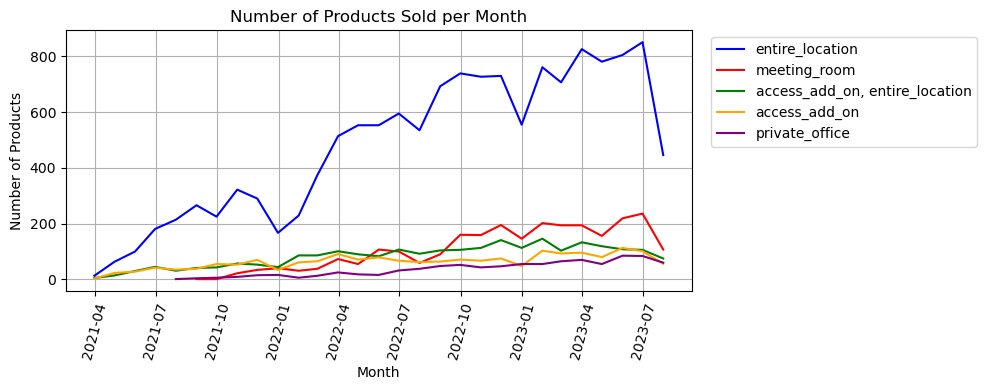

In [118]:
# entire_location_df = filtered_df[filtered_df['booking_product_type']=='entire_location']
# prod_basket_filtered = product_basket[product_basket['product_type_ordered'] == 'entire_location']

product_df = filtered_df.merge(product_basket, on='customer_email')

selected_product_types = ['entire_location', 'meeting_room', 'access_add_on, entire_location', 'access_add_on', 'private_office']
product_df = product_df[product_df['product_type_ordered'].isin(selected_product_types)]

  
    
product_df = product_df.groupby([pd.Grouper(key='date', freq='M'), 'product_type_ordered'])['order_id'].count().reset_index()
product_df.columns = ['Month', 'Product Type', 'Number of Orders']


plt.figure(figsize=(10, 4))

# Set the line colors for each product type
colors = ['blue', 'red', 'green', 'orange', 'purple']

# Iterate over each product type
for i, product_type in enumerate(selected_product_types):
    product_data = product_df[product_df['Product Type'] == product_type]
    sns.lineplot(x='Month', y='Number of Orders', data=product_data, color=colors[i], label=product_type)

# Set the chart title and axis labels
plt.title('Number of Products Sold per Month')
plt.xlabel('Month')
plt.ylabel('Number of Products')

# Set x-axis tick labels
plt.xticks(rotation=75)

# Add gridlines
plt.grid(True)

# Move the legend outside the chart
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()

plt.show()

**The entire_location distribution over time looks similar to that of all products sold. I want to check that individually.**

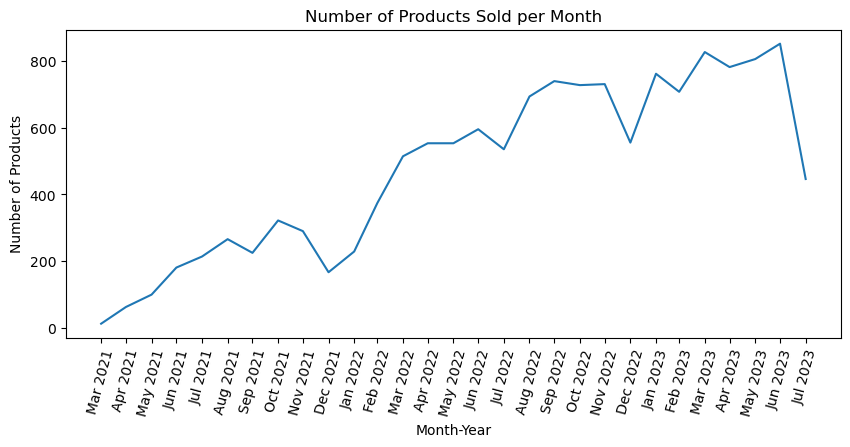

In [124]:
entire_location_df = filtered_df[filtered_df['booking_product_type']=='entire_location']
prod_basket_filtered = product_basket[product_basket['product_type_ordered'] == 'entire_location']

entire_location_df = filtered_df.merge(prod_basket_filtered, on='customer_email')

entire_location_df = pd.DataFrame(entire_location_df.resample('M', on='date')['order_id'].count())
entire_location_df.columns = ['number_of_entire_location_sold']
    
# entire_location_df.number_of_entire_location_sold.sum()
#13815 -- verified from earlier
    
# plot
plt.figure(figsize=(10, 4))
sns.lineplot(x=entire_location_df.index, y=entire_location_df['number_of_entire_location_sold'], color = plot_color)

# Set the chart title and axis labels
plt.title('Number of Products Sold per Month')
plt.xlabel('Month-Year')
plt.ylabel('Number of Products')

plt.xticks(prod_over_time_df.index, prod_over_time_df.index.strftime('%b %Y'), rotation=75)
plt.show()

**This distribution makes sense since the entire_location makes up the large majority of products. I will decide to stop my investigation of programmatic combinations of products here since entire_location is overwhelmingly ordered more than other products.**

**The top 3 products by customer were ordered on their own:**
1. entire_location
2. meeting_room
3. access_add_on

**The top 5 products by number of orders:**
1. entire_location
2. meeting_room
3. access_add_on, entire_location (customers that ordered these together over their lifetime)
4. access_add_on
5. private_office

**I will keep these in mind when looking into returning customers**

## Customer Deep-Dive

- RFM for customers and Employ the same process of cluttering
	1. Maximum transaction date for each customer (recency)
    2. Order count for each customer (frequency, counting 2 orders in the same day as 1)
    3. Sum of final price for each customer (monetary value)
    4. Lifetime of customer: last -first in days
    5. Average interval - lifetime in days/number of orders(frequency) 
    6. Lifetime Value per Customer
    
    
- Second order analysis: returning customers, why did they return? Where did they return (location, space)? 
- Second Order Matrix: compare returning customer's first order to second order to see why returning? Discount? What is the interval between orders?

**For the RFM, I want to inlcude**
1. Current day - maximum transaction date for each customer (recency)
2. Order count for each customer (frequency, counting 2 orders in the same day as 1)
3. Sum of final price for each customer (monetary value)
4. Lifetime of customer: last -first in days
5. Average interval - lifetime in days/number of orders(frequency) 


#### Frequency

In [144]:
#I want to start with a basic rfm, then build from there

rfm_df = filtered_df.loc[:, ['customer_email', 'order_id', 'created_at', 'final_price_usd']]
rfm_df['created_at'] = rfm_df.created_at.dt.date

# Instead of counting the order_id which will be distinct for orders happening on the same day, I will do a unique count of created_at dates per customer
frequency_rfm = rfm_df.groupby('customer_email')['created_at'].nunique().reset_index()


frequency_rfm

,customer_email,created_at
0,0488875@gmail.com,3
1,0524235148si@gmail.com,1
2,052kozoz@gmail.com,3
3,0584854855yos@gmail.com,1
4,0585171281@proton.me,1
...,...,...
14514,zviherzig@gmail.com,2
14515,zvikac@baseline.co.il,1
14516,zwilliams@figma.com,1
14517,zyamagin@gmail.com,2


#### Recency

In [145]:
rfm_df = filtered_df.groupby(['customer_email']).agg({'created_at':'max',
                                                      'final_price_usd':'sum'
                                                     }).reset_index()




rfm_df['today'] = pd.to_datetime('today')

rfm_df['created_at'] = rfm_df['created_at'].dt.date
rfm_df['today'] = rfm_df['today'].dt.date

rfm_df['recency'] = (rfm_df['today'] - rfm_df['created_at']).dt.days

rfm_df.rename(columns={'final_price_usd': 'monetary_value'}, inplace=True)

#rfm_df['created_at'] = rfm_df.created_at.dt.date
rfm_df.drop(['created_at', 'today'], axis=1, inplace=True)



#recency is now starting with 0 instead of -1 for orders on the same day since we are not taking hours into account
rfm_df.sort_values('recency', ascending=True)

,customer_email,monetary_value,recency
3554,artiom.giza@gmail.com,275.50,0
484,Dana.Nahum.adv@gmail.com,234.99,0
10251,mike.thornton01@gmail.com,35.72,0
10225,mickaeldavidchekroun@gmail.com,471.61,0
106,Ali.zaidi@cloudprimero.com,35.72,0
...,...,...,...
11482,pavel@ego.jobs,53.39,847
9545,manu7268@gmail.com,245.64,851
5459,dr.a.bulfon@gmx.net,70.37,851
2766,alberto@mikamai.com,35.72,853


#### Earliest and latest Order Dates & Lifetime Days

In [146]:
# Need to merge frequency_rfm
# I now want to add features: lifetime and avg interval in days
# Here I will add lifetime to the RFM

min_max_created_at = filtered_df.groupby('customer_email')['created_at'].agg(['min', 'max']).reset_index()
min_max_created_at.columns = ['customer_email', 'created_at_min', 'created_at_max']

# Merge min_max_created_at and frequency_rfm with rfm_df
rfm_df = rfm_df.merge(frequency_rfm, on='customer_email')
rfm_df = rfm_df.merge(min_max_created_at, on='customer_email')

# Calculate the lifetime in days
rfm_df['created_at_max'] = rfm_df.created_at_max.dt.date
rfm_df['created_at_min'] = rfm_df.created_at_min.dt.date
rfm_df['lifetime_days'] = (rfm_df['created_at_max'] - rfm_df['created_at_min']).dt.days

rfm_df.rename(columns={'created_at': 'frequency'}, inplace=True)

# Updated RFM DataFrame
rfm_df

,customer_email,monetary_value,recency,frequency,created_at_min,created_at_max,lifetime_days
0,0488875@gmail.com,76.21,55,3,2023-05-04,2023-05-23,19
1,0524235148si@gmail.com,40.85,217,1,2022-12-12,2022-12-12,0
2,052kozoz@gmail.com,132.84,165,3,2022-12-08,2023-02-02,56
3,0584854855yos@gmail.com,120.08,202,1,2022-12-27,2022-12-27,0
4,0585171281@proton.me,30.90,385,1,2022-06-27,2022-06-27,0
...,...,...,...,...,...,...,...
14514,zviherzig@gmail.com,76.81,160,2,2023-02-06,2023-02-07,1
14515,zvikac@baseline.co.il,34.46,11,1,2023-07-06,2023-07-06,0
14516,zwilliams@figma.com,63.22,416,1,2022-05-27,2022-05-27,0
14517,zyamagin@gmail.com,143.79,148,2,2023-02-09,2023-02-19,10


#### Average Interval between Orders

In [147]:
#Here I will add the average interval between orders per customer

#I will sort the dates by customer, and then use .shift to perform a sort of lag operation on the dates
sorted_date = filtered_df[['customer_email', 'created_at']].sort_values(by=['customer_email', 'created_at'], ascending=[True, True], ignore_index=True)

sorted_date['created_at']=sorted_date['created_at'].dt.date

sorted_date['previous_order'] = sorted_date.groupby(['customer_email'])['created_at'].shift()

# From this, days between visits is simply the difference:
sorted_date['interval_days'] = (sorted_date['created_at'] - sorted_date['previous_order']).dt.days

# Average days between visits:
avg_interval_df = sorted_date.groupby('customer_email')['interval_days'].mean().reset_index()
avg_interval_df.columns = ['customer_email', 'avg_interval_days']


avg_interval_df.sort_values('avg_interval_days', ascending=False).head(30)

,customer_email,avg_interval_days
9967,mckayla@collectiveclimb.org,695.0
5190,dbeissert@aspenmp.com,685.0
10277,mikeygordon@gmail.com,601.0
6558,graham.staton@gmail.com,572.0
2522,accounts@macrael.com,556.0
9198,lise.kelchlin@gmail.com,554.0
4478,charlottealtmann@gmail.com,545.0
7847,joachim.schaeffer@posteo.de,536.0
10724,nats_1602@hotmail.com,527.0
12114,rohar@posteo.de,526.0


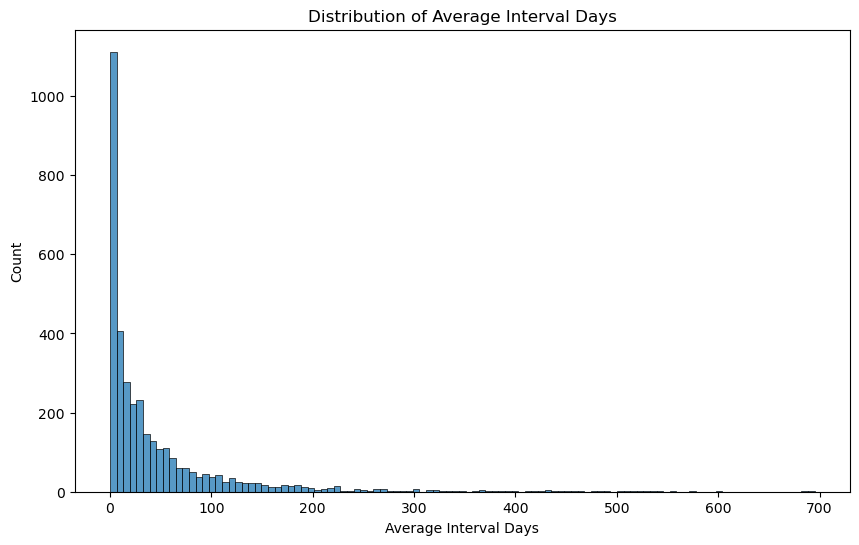

In [148]:
# distribution of avg_interval_days

plt.figure(figsize=(10, 6))
sns.histplot(avg_interval_df['avg_interval_days'], kde=False)
plt.xlabel('Average Interval Days')
plt.ylabel('Count')
plt.title('Distribution of Average Interval Days')
plt.show()

In [149]:
# Merge avg_interval_df with rfm_df
rfm_df = rfm_df.merge(avg_interval_df, on='customer_email')

rfm_df.head()

,customer_email,monetary_value,recency,frequency,created_at_min,created_at_max,lifetime_days,avg_interval_days
0,0488875@gmail.com,76.21,55,3,2023-05-04,2023-05-23,19,9.5
1,0524235148si@gmail.com,40.85,217,1,2022-12-12,2022-12-12,0,NaN
2,052kozoz@gmail.com,132.84,165,3,2022-12-08,2023-02-02,56,28.0
3,0584854855yos@gmail.com,120.08,202,1,2022-12-27,2022-12-27,0,NaN
4,0585171281@proton.me,30.90,385,1,2022-06-27,2022-06-27,0,NaN


#### Lifetime Value per Customer

In [150]:
# Add customer lifetime value per customer to the RFM

rfm_df['customer_ltv'] = ((rfm_df['monetary_value'] * rfm_df['frequency'])).round(2)

rfm_df.sort_values('avg_interval_days', ascending=False)

,customer_email,monetary_value,recency,frequency,created_at_min,created_at_max,lifetime_days,avg_interval_days,customer_ltv
9967,mckayla@collectiveclimb.org,60.00,31,2,2021-07-21,2023-06-16,695,695.0,120.00
5190,dbeissert@aspenmp.com,104.91,69,2,2021-06-23,2023-05-09,685,685.0,209.82
10277,mikeygordon@gmail.com,102.70,147,2,2021-06-29,2023-02-20,601,601.0,205.40
6558,graham.staton@gmail.com,62.00,131,2,2021-08-13,2023-03-08,572,572.0,124.00
2522,accounts@macrael.com,75.00,70,2,2021-10-29,2023-05-08,556,556.0,150.00
...,...,...,...,...,...,...,...,...,...
14511,zurgul@gmail.com,28.68,92,1,2023-04-16,2023-04-16,0,NaN,28.68
14513,zvid@globe-er.com,177.28,328,1,2022-08-23,2022-08-23,0,NaN,177.28
14515,zvikac@baseline.co.il,34.46,11,1,2023-07-06,2023-07-06,0,NaN,34.46
14516,zwilliams@figma.com,63.22,416,1,2022-05-27,2022-05-27,0,NaN,63.22


In [151]:
# Stats for the RFM for all customers over entire span of data

rfm_df.describe()

,monetary_value,recency,frequency,lifetime_days,avg_interval_days,customer_ltv
count,14519.000000,14519.000000,14519.000000,14519.000000,3565.000000,14519.000000
mean,170.861554,282.172395,1.550658,22.454921,45.771600,723.361010
std,435.914195,205.526360,1.808288,73.475282,74.234629,9477.500447
min,0.680000,0.000000,1.000000,0.000000,0.000000,0.680000
25%,35.000000,109.000000,1.000000,0.000000,4.000000,35.000000
50%,62.270000,252.000000,1.000000,0.000000,19.000000,65.600000
75%,150.000000,420.000000,1.000000,0.000000,54.000000,210.000000
max,21734.280000,854.000000,43.000000,808.000000,695.000000,934574.040000


### Basic RFM Features Analysis 

I want to use the same scaling performed on Operators to begin to see which customers are high value. I will utilize the same quantiles function to assign the quartile for each feature and get a cumulative score

In [286]:
#Remove the min and max dates for analysis

rfm_copy = rfm_df.copy()

rfm_analysis_df = rfm_copy.drop(['created_at_min', 'created_at_max'], axis=1)

rfm_analysis_df

,customer_email,monetary_value,recency,frequency,lifetime_days,avg_interval_days,customer_ltv
0,0488875@gmail.com,76.21,55,3,19,9.5,228.63
1,0524235148si@gmail.com,40.85,217,1,0,NaN,40.85
2,052kozoz@gmail.com,132.84,165,3,56,28.0,398.52
3,0584854855yos@gmail.com,120.08,202,1,0,NaN,120.08
4,0585171281@proton.me,30.90,385,1,0,NaN,30.90
...,...,...,...,...,...,...,...
14514,zviherzig@gmail.com,76.81,160,2,1,1.0,153.62
14515,zvikac@baseline.co.il,34.46,11,1,0,NaN,34.46
14516,zwilliams@figma.com,63.22,416,1,0,NaN,63.22
14517,zyamagin@gmail.com,143.79,148,2,10,10.0,287.58


In [165]:
#I want to use the ntiles as a reference when grouping each customer by quartiles

rfm_quantiles = rfm_analysis_df[['monetary_value', 'recency', 'frequency', 'lifetime_days', 'avg_interval_days', 'customer_ltv']].quantile(q=[0.25,0.5,0.75])

rfm_quantiles

,monetary_value,recency,frequency,lifetime_days,avg_interval_days,customer_ltv
0.25,35.00,109.0,1.0,0.0,4.0,35.0
0.50,62.27,252.0,1.0,0.0,19.0,65.6
0.75,150.00,420.0,1.0,0.0,54.0,210.0


**By leaving in one-time customers (with lifetime_days == 0) this skews the quartiles for this field. The same goes for the frequency field. I will separate these customers to get only the returning customers so these quartiles are not skewed.**

In [166]:
rfm_quantiles.to_dict()

# Arguments (x = value, p = recency, avg interval days, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
# Arguments (x = value, p = monetary, frequency, lifetime days, customer ltv, d = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [167]:
#create rfm segmentation table
rfm_segmentation = rfm_copy

rfm_segmentation['r_quartile'] = rfm_segmentation['recency'].apply(RScore, args=('recency',rfm_quantiles))
rfm_segmentation['avg_interval_quartile'] = rfm_segmentation['avg_interval_days'].apply(RScore, args=('avg_interval_days',rfm_quantiles))

rfm_segmentation['f_quartile'] = rfm_segmentation['frequency'].apply(FMScore, args=('frequency',rfm_quantiles))
rfm_segmentation['m_quartile'] = rfm_segmentation['monetary_value'].apply(FMScore, args=('monetary_value',rfm_quantiles))
rfm_segmentation['lifetime_days_quartile'] = rfm_segmentation['lifetime_days'].apply(FMScore, args=('lifetime_days',rfm_quantiles))
rfm_segmentation['customer_ltv_quartile'] = rfm_segmentation['customer_ltv'].apply(FMScore, args=('customer_ltv',rfm_quantiles))



In [168]:
rfm_segmentation

,customer_email,monetary_value,recency,frequency,created_at_min,created_at_max,lifetime_days,avg_interval_days,customer_ltv,r_quartile,avg_interval_quartile,f_quartile,m_quartile,lifetime_days_quartile,customer_ltv_quartile
0,0488875@gmail.com,76.21,55,3,2023-05-04,2023-05-23,19,9.5,228.63,4,3,4,3,4,4
1,0524235148si@gmail.com,40.85,217,1,2022-12-12,2022-12-12,0,NaN,40.85,3,1,1,2,1,2
2,052kozoz@gmail.com,132.84,165,3,2022-12-08,2023-02-02,56,28.0,398.52,3,2,4,3,4,4
3,0584854855yos@gmail.com,120.08,202,1,2022-12-27,2022-12-27,0,NaN,120.08,3,1,1,3,1,3
4,0585171281@proton.me,30.90,385,1,2022-06-27,2022-06-27,0,NaN,30.90,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14514,zviherzig@gmail.com,76.81,160,2,2023-02-06,2023-02-07,1,1.0,153.62,3,4,4,3,4,3
14515,zvikac@baseline.co.il,34.46,11,1,2023-07-06,2023-07-06,0,NaN,34.46,4,1,1,1,1,1
14516,zwilliams@figma.com,63.22,416,1,2022-05-27,2022-05-27,0,NaN,63.22,2,1,1,3,1,2
14517,zyamagin@gmail.com,143.79,148,2,2023-02-09,2023-02-19,10,10.0,287.58,3,3,4,3,4,4


In [193]:
#rfm_segmentation.sort_values(by=['r_quartile', 'avg_interval_quartile', 'f_quartile', 'm_quartile', 'lifetime_days_quartile', 'customer_ltv_quartile'], ascending=[True, True, False, False, False, False])

rfm_segmentation['RFMScore'] = rfm_segmentation.r_quartile.map(str) \
                            + rfm_segmentation.avg_interval_quartile.map(str) \
                            + rfm_segmentation.m_quartile.map(str) \
                            + rfm_segmentation.f_quartile.map(str) \
                            + rfm_segmentation.lifetime_days_quartile.map(str) \
                            + rfm_segmentation.customer_ltv_quartile.map(str)


rfm_segmentation.sort_values('RFMScore', ascending=False, ignore_index=True).head(20)


,customer_email,monetary_value,recency,frequency,created_at_min,created_at_max,lifetime_days,avg_interval_days,customer_ltv,r_quartile,avg_interval_quartile,f_quartile,m_quartile,lifetime_days_quartile,customer_ltv_quartile,RFMScore
0,sarafiskray@gmail.com,275.00,18,2,2023-06-27,2023-06-29,2,2.000000,550.00,4,4,4,4,4,4,444444
1,Hilakralaw@gmail.com,191.76,75,3,2023-04-27,2023-05-03,6,3.000000,575.28,4,4,4,4,4,4,444444
2,pdallaire@mindeducation.org,660.00,35,2,2023-06-05,2023-06-12,7,3.500000,1320.00,4,4,4,4,4,4,444444
3,Zach.barrett@akasa.com,240.00,80,4,2023-04-18,2023-04-28,10,3.333333,960.00,4,4,4,4,4,4,444444
4,rami@anatifamily.com,295.94,70,2,2023-05-07,2023-05-08,1,1.000000,591.88,4,4,4,4,4,4,444444
5,red.dacquel@us.nestle.com,920.00,91,2,2023-04-14,2023-04-17,3,1.500000,1840.00,4,4,4,4,4,4,444444
6,aaronargyres@gmail.com,370.00,90,2,2023-04-17,2023-04-18,1,0.500000,740.00,4,4,4,4,4,4,444444
7,garnerlanier@gmail.com,268.05,4,4,2023-07-05,2023-07-13,8,2.666667,1072.20,4,4,4,4,4,4,444444
8,fhaya@hotmail.com,594.65,4,6,2023-06-26,2023-07-13,17,3.400000,3567.90,4,4,4,4,4,4,444444
9,adops@notsy.io,258.27,11,2,2023-07-02,2023-07-06,4,4.000000,516.54,4,4,4,4,4,4,444444


In [179]:
rfm_seg_grouped = rfm_segmentation.groupby('RFMScore')['customer_email'].count().reset_index()

rfm_seg_grouped.sort_values('RFMScore', ascending=False, ignore_index=True)

,RFMScore,customer_email
0,444444,50
1,444114,35
2,444113,5
3,443444,25
4,443443,52
...,...,...
104,113113,594
105,113112,39
106,112443,9
107,112112,676


**There are 50 customers that achieved top quartiles for all features. These are the highest value customers based on the basic rfm analysis. I want to see if they are still high value with the inclusion of other features.**

### Business Questions to answer with the RFM

**1. Who is more engaged?**

I want to examine the frequency and avg_interval_days columns to identify customers who have a higher frequency of orders and shorter average intervals between orders. These customers can be considered more engaged.
- Scatter plot: visualize freq vs. avg interval days

In [282]:
# I can first look at the subset of customers who were in the top 2 quartiles for: frequency, avg_interval_days

engagement_df = rfm_segmentation[(rfm_segmentation['f_quartile'].isin([3, 4])) & 
                                 (rfm_segmentation['avg_interval_quartile'].isin([3, 4]))
                                ]

engagement_df

,customer_email,monetary_value,recency,frequency,created_at_min,created_at_max,lifetime_days,avg_interval_days,customer_ltv,r_quartile,avg_interval_quartile,f_quartile,m_quartile,lifetime_days_quartile,customer_ltv_quartile,RFMScore
0,0488875@gmail.com,76.21,55,3,2023-05-04,2023-05-23,19,9.50,228.63,4,3,4,3,4,4,433444
5,08-ottoman.burly@icloud.com,58.00,284,2,2022-10-05,2022-10-06,1,1.00,116.00,2,4,4,2,4,3,242443
23,7769747@gmail.com,89.47,148,3,2023-02-14,2023-02-19,5,2.50,268.41,3,4,4,3,4,4,343444
33,93romanov@gmail.com,55.15,193,2,2023-01-04,2023-01-05,1,1.00,110.30,3,4,4,2,4,3,342443
61,Adelea@giftverse.ai,63.52,54,2,2023-05-17,2023-05-24,7,7.00,127.04,4,3,4,3,4,3,433443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14490,zlaasu@gmail.com,126.73,242,5,2022-09-19,2022-11-17,59,14.75,633.65,3,3,4,3,4,4,333444
14510,zsisco@icloud.com,87.00,74,3,2023-05-02,2023-05-04,2,1.00,261.00,4,4,4,3,4,4,443444
14512,zurismith99@gmail.com,70.00,158,2,2023-02-08,2023-02-09,1,1.00,140.00,3,4,4,3,4,3,343443
14514,zviherzig@gmail.com,76.81,160,2,2023-02-06,2023-02-07,1,1.00,153.62,3,4,4,3,4,3,343443


In [284]:
engagement_df.sort_values('RFMScore', ascending=False)

,customer_email,monetary_value,recency,frequency,created_at_min,created_at_max,lifetime_days,avg_interval_days,customer_ltv,r_quartile,avg_interval_quartile,f_quartile,m_quartile,lifetime_days_quartile,customer_ltv_quartile,RFMScore
2192,Tayahyazeed@gmail.com,244.89,27,2,2023-06-16,2023-06-20,4,4.0,489.78,4,4,4,4,4,4,444444
852,Hilakralaw@gmail.com,191.76,75,3,2023-04-27,2023-05-03,6,3.0,575.28,4,4,4,4,4,4,444444
12553,schedulermobilesystems@gmail.com,162.57,77,2,2023-04-23,2023-05-01,8,4.0,325.14,4,4,4,4,4,4,444444
5029,daniel@ubicloud.com,460.00,21,2,2023-06-23,2023-06-26,3,3.0,920.00,4,4,4,4,4,4,444444
2617,adops@notsy.io,258.27,11,2,2023-07-02,2023-07-06,4,4.0,516.54,4,4,4,4,4,4,444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9556,manzoor.razaak@ia-grp.com,65.28,684,2,2021-08-25,2021-09-01,7,7.0,130.56,1,3,4,3,4,3,133443
10692,natalie.gavilanes@gmail.com,64.00,426,2,2022-05-12,2022-05-17,5,5.0,128.00,1,3,4,3,4,3,133443
2671,agne.jotautaite@savings-united.com,52.26,707,2,2021-08-04,2021-08-09,5,5.0,104.52,1,3,4,2,4,3,132443
1032,Jeremyhaddad4@gmail.com,61.88,425,2,2022-05-10,2022-05-18,8,8.0,123.76,1,3,4,2,4,3,132443


**I can see that these quartiles are skewed for lifetime and frequency. For further analysis I will use only the returning customers to better understand the behaviors of high value customers.**

### Returning Customer Analysis

##### I want to see the number and characteristics of one-timers, and will get a first glimpse from the RFM by filtering for:
- days from first order > 30 days (distinguish from new customers)
- lifetime_days == 0 (customer made purchase within 1 day and did not return)

##### I want to compare the re-order rate for returning users who received a discount on the first order vs those who did not.
- Compare for promotion on first order
- Corr coeff?
- Other features?

##### I want to create a boolean matrix for returning customers that will result in a score indicating high value based on the following metrics:
- Refer to data for appropriate fields

**Who are returning customers? What makes them return?**

Explore the second_order_promo_code column to identify customers who used a promotion code on their second order. 
Compare their behavior with customers who did not use a promotion code to determine if the presence of a promotion code influenced their decision to return.
Analyze geographic factors such as so_country, so_state, and so_city to identify any patterns or preferences among returning customers based on their location.
Investigate the days_between_1st_2nd_order column to understand the time gap between the first and second orders. Identify any trends or patterns that indicate a shorter gap between orders for returning customers.


In [268]:
#I will first add relevant metrics to the rfm_segmentation to provide more information per group of customers once filtered
# I will create a copy to do so if changes are needed

rfm_df_2 = rfm_segmentation.copy()

In [269]:
#To join other metrics, I want to pull them from filtered_df 
additional_metrics =  filtered_df.loc[:, ['customer_email', 
                                          'operator_name',
                                          'country',
                                          'state',
                                          'city',
                                          'space_name',
                                          'created_at',
                                          'promotion_code',
                                          'final_price_usd',
                                          'discounted_amount_usd',
                                          'booking_product_type',
                                          'quantity'
                                        ]]

#additional_metrics['created_at'] = additional_metrics.created_at.dt.date


additional_metrics = additional_metrics.sort_values(by=['customer_email', 'created_at'])

**First Order Dataframe**

In [270]:
#I want to group by customer_id and then create the columns: 
# first_order_date, 
# second_order_date, 
# days_between_orders, 
# discount_first_order, 
# discount_second_order, 
# promo_code_first_order, 
# promo_code_second_order

first_order_df = additional_metrics.groupby('customer_email').first().reset_index()
first_order_df.rename(columns={'operator_name':'fo_operator_name',
                               'country':'fo_country',
                               'state':'fo_state',
                               'city':'fo_city',
                               'space_name':'fo_space_name',
                               'created_at': 'first_order_date',
                               'discounted_amount_usd':'first_order_discount',
                               'promotion_code':'first_order_promo_code',
                               'final_price_usd':'first_order_price_usd',
                               'booking_product_type':'fo_booking_product_type',
                               'quantity':'fo_quantity'
                               }, inplace=True)

first_order_df['first_order_date'] = first_order_df['first_order_date'].dt.date

first_order_df.shape

(14519, 12)

In [271]:
additional_metrics['created_at'] = additional_metrics['created_at'].dt.date


**Second Order Dataframe**

In [273]:
#I want to take into account that if cusomter's second order was on the same day, then this counts as 1 day of activity

diff_day_second_order_df =  additional_metrics.groupby(['customer_email']).apply(lambda x: x.iloc[1] if len(x) > 1 and x.iloc[1]['created_at'] != x.iloc[0]['created_at'] else None).reset_index(drop=True)


diff_day_second_order_df.rename(columns={'created_at': 'second_order_date',
                               'discounted_amount_usd':'second_order_discount',
                               'promotion_code':'second_order_promo_code',
                               'final_price_usd':'so_final_price_usd',
                               'operator_name':'so_operator_name',
                               'country':'so_country',
                               'state':'so_state',
                               'city':'so_city',
                               'space_name':'so_space_name',
                               'booking_product_type':'so_booking_product_type',
                               'quantity':'so_quantity'
                               }, inplace=True)

diff_day_second_order_df.dropna(subset=['customer_email'], inplace=True)

diff_day_second_order_df.shape

(3151, 12)

**Merge with rfm_df_2**

In [274]:
rfm_rca_df = rfm_df_2.merge(first_order_df, on='customer_email', how='left')
rfm_rca_df = rfm_rca_df.merge(diff_day_second_order_df, on='customer_email', how='left')

rfm_rca_df.shape

(14519, 38)

**Add an interval between first and second orders field**

In [275]:
rfm_rca_df['days_between_1st_2nd_order'] = (rfm_rca_df['second_order_date'] - rfm_rca_df['first_order_date']).dt.days

rfm_rca_df.head()

,customer_email,monetary_value,recency,frequency,created_at_min,created_at_max,lifetime_days,avg_interval_days,customer_ltv,r_quartile,avg_interval_quartile,f_quartile,m_quartile,lifetime_days_quartile,customer_ltv_quartile,RFMScore,fo_operator_name,fo_country,fo_state,fo_city,fo_space_name,first_order_date,first_order_promo_code,first_order_price_usd,first_order_discount,fo_booking_product_type,fo_quantity,so_operator_name,so_country,so_state,so_city,so_space_name,second_order_date,second_order_promo_code,so_final_price_usd,second_order_discount,so_booking_product_type,so_quantity,days_between_1st_2nd_order
0,0488875@gmail.com,76.21,55,3,2023-05-04,2023-05-23,19,9.5,228.63,4,3,4,3,4,4,433444,Urban Place,IL,None,Tel Aviv,UP Day Pass,2023-05-04,,25.48,0.0,entire_location,1.0,Urban Place,IL,None,Tel Aviv,UP Day Pass,2023-05-18,,25.41,0.0,entire_location,1.0,14.0
1,0524235148si@gmail.com,40.85,217,1,2022-12-12,2022-12-12,0,NaN,40.85,3,1,1,2,1,2,312112,WeWork Israel,IL,None,Ramat Gan,Open Workspace Day Pass,2022-12-12,None,40.85,0.0,entire_location,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,052kozoz@gmail.com,132.84,165,3,2022-12-08,2023-02-02,56,28.0,398.52,3,2,4,3,4,4,323444,Urban Place,IL,None,Jerusalem,UP Office Day Pass - 1p,2022-12-08,None,50.59,0.0,private_office,1.0,Urban Place,IL,None,Jerusalem,UP Office Day Pass - 1p,2023-01-26,None,51.42,0.0,private_office,1.0,49.0
3,0584854855yos@gmail.com,120.08,202,1,2022-12-27,2022-12-27,0,NaN,120.08,3,1,1,3,1,3,313113,WeWork Israel,IL,None,Jerusalem,Meeting Room 2B,2022-12-27,None,120.08,0.0,meeting_room,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0585171281@proton.me,30.90,385,1,2022-06-27,2022-06-27,0,NaN,30.90,2,1,1,1,1,1,211111,WeWork Israel,IL,None,Haifa,Open Workspace Day Pass,2022-06-27,None,30.90,0.0,entire_location,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### One-Time Customers

Characterized by:
- days from first order > 30 days
- second order date is null
- lifetime days is 0

In [276]:
#to distinguish between new and old customers I will make a field for days from their first order

rfm_rca_df['today'] = pd.to_datetime('today')

rfm_rca_df['today'] = rfm_rca_df['today'].dt.date

rfm_rca_df['days_from_fo'] = (rfm_rca_df['today'] - rfm_rca_df['first_order_date']).dt.days


rfm_rca_df.head()

,customer_email,monetary_value,recency,frequency,created_at_min,created_at_max,lifetime_days,avg_interval_days,customer_ltv,r_quartile,avg_interval_quartile,f_quartile,m_quartile,lifetime_days_quartile,customer_ltv_quartile,RFMScore,fo_operator_name,fo_country,fo_state,fo_city,fo_space_name,first_order_date,first_order_promo_code,first_order_price_usd,first_order_discount,fo_booking_product_type,fo_quantity,so_operator_name,so_country,so_state,so_city,so_space_name,second_order_date,second_order_promo_code,so_final_price_usd,second_order_discount,so_booking_product_type,so_quantity,days_between_1st_2nd_order,today,days_from_fo
0,0488875@gmail.com,76.21,55,3,2023-05-04,2023-05-23,19,9.5,228.63,4,3,4,3,4,4,433444,Urban Place,IL,None,Tel Aviv,UP Day Pass,2023-05-04,,25.48,0.0,entire_location,1.0,Urban Place,IL,None,Tel Aviv,UP Day Pass,2023-05-18,,25.41,0.0,entire_location,1.0,14.0,2023-07-18,75
1,0524235148si@gmail.com,40.85,217,1,2022-12-12,2022-12-12,0,NaN,40.85,3,1,1,2,1,2,312112,WeWork Israel,IL,None,Ramat Gan,Open Workspace Day Pass,2022-12-12,None,40.85,0.0,entire_location,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-07-18,218
2,052kozoz@gmail.com,132.84,165,3,2022-12-08,2023-02-02,56,28.0,398.52,3,2,4,3,4,4,323444,Urban Place,IL,None,Jerusalem,UP Office Day Pass - 1p,2022-12-08,None,50.59,0.0,private_office,1.0,Urban Place,IL,None,Jerusalem,UP Office Day Pass - 1p,2023-01-26,None,51.42,0.0,private_office,1.0,49.0,2023-07-18,222
3,0584854855yos@gmail.com,120.08,202,1,2022-12-27,2022-12-27,0,NaN,120.08,3,1,1,3,1,3,313113,WeWork Israel,IL,None,Jerusalem,Meeting Room 2B,2022-12-27,None,120.08,0.0,meeting_room,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-07-18,203
4,0585171281@proton.me,30.90,385,1,2022-06-27,2022-06-27,0,NaN,30.90,2,1,1,1,1,1,211111,WeWork Israel,IL,None,Haifa,Open Workspace Day Pass,2022-06-27,None,30.90,0.0,entire_location,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-07-18,386


In [277]:
one_time_df = rfm_rca_df[(rfm_rca_df['days_from_fo'] > 30) &
                           (rfm_rca_df['second_order_date'].isnull()) & 
                           (rfm_rca_df['lifetime_days'] == 0)
                        ]

one_time_df.describe()

,monetary_value,recency,frequency,lifetime_days,avg_interval_days,customer_ltv,r_quartile,avg_interval_quartile,f_quartile,m_quartile,lifetime_days_quartile,customer_ltv_quartile,first_order_price_usd,first_order_discount,fo_quantity,so_final_price_usd,second_order_discount,so_quantity,days_between_1st_2nd_order,days_from_fo
count,10472.000000,10472.000000,10472.0,10472.0,268.0,10472.000000,10472.000000,10472.000000,10472.0,10472.000000,10472.0,10472.000000,10472.000000,10472.000000,10470.000000,0.0,0.0,0.0,0.0,10472.000000
mean,102.702956,313.613541,1.0,0.0,0.0,102.702956,2.332697,1.076776,1.0,2.122995,1.0,2.059206,95.744498,3.120249,1.172206,NaN,NaN,NaN,NaN,314.613541
std,188.762446,198.589542,0.0,0.0,0.0,188.762446,1.062774,0.473767,0.0,1.103367,0.0,1.034007,145.676916,22.727760,0.688768,NaN,NaN,NaN,NaN,198.589542
min,0.680000,30.000000,1.0,0.0,0.0,0.680000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,0.680000,0.000000,1.000000,NaN,NaN,NaN,NaN,31.000000
25%,34.580000,147.000000,1.0,0.0,0.0,34.580000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,34.460000,0.000000,1.000000,NaN,NaN,NaN,NaN,148.000000
50%,41.155000,283.000000,1.0,0.0,0.0,41.155000,2.000000,1.000000,1.0,2.000000,1.0,2.000000,40.755000,0.000000,1.000000,NaN,NaN,NaN,NaN,284.000000
75%,100.000000,446.000000,1.0,0.0,0.0,100.000000,3.000000,1.000000,1.0,3.000000,1.0,3.000000,100.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,447.000000
max,5425.080000,854.000000,1.0,0.0,0.0,5425.080000,4.000000,4.000000,1.0,4.000000,1.0,4.000000,3000.000000,522.030000,20.000000,NaN,NaN,NaN,NaN,855.000000


#### Returning Customers

In [278]:
# I want to compare these stats to returning customers:
# excluding new customers

returning_customers_df = rfm_rca_df[(rfm_rca_df['days_from_fo'] > 30) &
                                    (rfm_rca_df['second_order_date'].notnull()) #taking this out gives 3174 returning customers
                                    &
                                    (rfm_rca_df['lifetime_days'] >= 1) 
                                     ]

# one_time_df = rfm_rca_df[(rfm_rca_df['days_from_fo'] > 30) &
#                            (rfm_rca_df['second_order_date'].isnull()) & 
#                            (rfm_rca_df['lifetime_days'] == 0)
#                         ]


print(returning_customers_df.shape)
returning_customers_df.describe()

(3058, 41)


,monetary_value,recency,frequency,lifetime_days,avg_interval_days,customer_ltv,r_quartile,avg_interval_quartile,f_quartile,m_quartile,lifetime_days_quartile,customer_ltv_quartile,first_order_price_usd,first_order_discount,fo_quantity,so_final_price_usd,second_order_discount,so_quantity,days_between_1st_2nd_order,days_from_fo
count,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.0,3058.000000,3058.0,3058.000000,3058.00000,3058.000000,3058.000000,3058.000000,3058.000000,3057.000000,3058.000000,3058.000000
mean,379.239908,252.949313,3.432963,102.493460,52.223950,2629.293591,2.656965,2.326357,4.0,3.500000,4.0,3.723022,101.59330,3.663620,1.198169,100.506969,4.625719,1.176317,50.901243,356.442773
std,728.638497,197.836884,3.015431,127.968621,77.489641,19347.059090,1.121234,1.074018,0.0,0.602714,0.0,0.449038,140.45171,25.367204,0.742184,128.401516,30.889449,0.613431,84.488130,199.274351
min,27.380000,0.000000,2.000000,1.000000,0.333333,54.760000,1.000000,1.000000,4.0,1.000000,4.0,2.000000,13.69000,0.000000,1.000000,12.810000,0.000000,1.000000,1.000000,32.000000
25%,90.000000,81.000000,2.000000,9.250000,7.000000,192.000000,2.000000,1.000000,4.0,3.000000,4.0,3.000000,34.56000,0.000000,1.000000,34.782500,0.000000,1.000000,5.000000,189.250000
50%,178.650000,215.000000,2.000000,50.000000,25.500000,463.815000,3.000000,2.000000,4.0,4.000000,4.0,4.000000,45.00000,0.000000,1.000000,50.000000,0.000000,1.000000,17.000000,330.000000
75%,398.060000,389.750000,4.000000,147.000000,62.000000,1315.822500,4.000000,3.000000,4.0,4.000000,4.0,4.000000,116.00000,0.000000,1.000000,119.157500,0.000000,1.000000,56.000000,498.750000
max,21734.280000,832.000000,43.000000,808.000000,695.000000,934574.040000,4.000000,4.000000,4.0,4.000000,4.0,4.000000,2600.97000,480.000000,20.000000,1415.150000,800.000000,10.000000,695.000000,853.000000


#### New Customers

In [279]:
new_customers_df = rfm_rca_df[(rfm_rca_df['days_from_fo'] <= 30 ) 
                             ]

# returning_customers_df = rfm_rca_df[(rfm_rca_df['recency'] > 30) &
#                                      (rfm_rca_df['lifetime_days'] > 30) &
#                                      (rfm_rca_df['second_order_date'].notnull())
#                                      ]

# one_time_df = rfm_rca_df[(rfm_rca_df['recency'] > 30) &
#                            (rfm_rca_df['second_order_date'].isnull()) & 
#                            (rfm_rca_df['lifetime_days'] == 0)]


new_customers_df.describe()
#91+ new+returning
#776+ onetime+returning
#867 total

,monetary_value,recency,frequency,lifetime_days,avg_interval_days,customer_ltv,r_quartile,avg_interval_quartile,f_quartile,m_quartile,lifetime_days_quartile,customer_ltv_quartile,first_order_price_usd,first_order_discount,fo_quantity,so_final_price_usd,second_order_discount,so_quantity,days_between_1st_2nd_order,days_from_fo
count,868.000000,868.000000,868.000000,868.000000,118.000000,868.000000,868.0,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,93.000000,93.000000,93.000000,93.000000,868.000000
mean,122.568790,14.347926,1.148618,0.750000,4.115254,160.310449,4.0,1.364055,1.328341,2.332949,1.328341,2.315668,100.164032,4.354263,1.153226,85.402258,0.563978,1.107527,5.258065,16.097926
std,207.415428,8.829862,0.501242,3.077385,5.275892,345.061641,0.0,0.938082,0.937138,1.127806,0.937138,1.111701,143.829576,22.065877,0.520204,114.082171,3.183723,0.402772,5.700693,8.773103
min,16.000000,0.000000,1.000000,0.000000,0.000000,16.000000,4.0,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,0.000000,1.000000,23.650000,0.000000,1.000000,1.000000,1.000000
25%,35.000000,6.000000,1.000000,0.000000,1.000000,35.000000,4.0,1.000000,1.000000,1.000000,1.000000,1.000000,34.730000,0.000000,1.000000,34.700000,0.000000,1.000000,1.000000,8.000000
50%,50.000000,14.000000,1.000000,0.000000,2.000000,53.990000,4.0,1.000000,1.000000,2.000000,1.000000,2.000000,41.170000,0.000000,1.000000,41.090000,0.000000,1.000000,3.000000,15.000000
75%,125.000000,22.000000,1.000000,0.000000,6.500000,149.752500,4.0,1.000000,1.000000,3.000000,1.000000,3.000000,109.440000,0.000000,1.000000,80.000000,0.000000,1.000000,7.000000,25.000000
max,2688.000000,29.000000,6.000000,28.000000,28.000000,4645.260000,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,1575.000000,240.000000,8.000000,693.000000,20.230000,3.000000,28.000000,30.000000


### Business Questions to answer with the Returning Customers RFM

**1. Who is more engaged?**

I want to examine the frequency and avg_interval_days columns to identify customers who have a higher frequency of orders and shorter average intervals between orders. These customers can be considered more engaged.
- Scatter plot: visualize freq vs. avg interval days

In [294]:
# With the returning_customers_df, I can now answer this question and adjust the RFMScore.

return_rfm_quantiles = returning_customers_df[['monetary_value', 'recency', 'frequency', 'lifetime_days', 'avg_interval_days', 'customer_ltv']].quantile(q=[0.25,0.5,0.75])

return_rfm_quantiles

,monetary_value,recency,frequency,lifetime_days,avg_interval_days,customer_ltv
0.25,90.00,81.00,2.0,9.25,7.0,192.0000
0.50,178.65,215.00,2.0,50.00,25.5,463.8150
0.75,398.06,389.75,4.0,147.00,62.0,1315.8225


**These values are much better in to investigate, but it should be considered that these are only for returning customers**

In [295]:
returning_customers_df2 = returning_customers_df.drop(['r_quartile', 'avg_interval_quartile', 'f_quartile', 'm_quartile', 'lifetime_days_quartile', 'customer_ltv_quartile', 'RFMScore'], axis=1)

returning_customers_df2

,customer_email,monetary_value,recency,frequency,created_at_min,created_at_max,lifetime_days,avg_interval_days,customer_ltv,fo_operator_name,fo_country,fo_state,fo_city,fo_space_name,first_order_date,first_order_promo_code,first_order_price_usd,first_order_discount,fo_booking_product_type,fo_quantity,so_operator_name,so_country,so_state,so_city,so_space_name,second_order_date,second_order_promo_code,so_final_price_usd,second_order_discount,so_booking_product_type,so_quantity,days_between_1st_2nd_order,today,days_from_fo
0,0488875@gmail.com,76.21,55,3,2023-05-04,2023-05-23,19,9.500000,228.63,Urban Place,IL,None,Tel Aviv,UP Day Pass,2023-05-04,,25.48,0.0,entire_location,1.0,Urban Place,IL,None,Tel Aviv,UP Day Pass,2023-05-18,,25.41,0.0,entire_location,1.0,14.0,2023-07-18,75
2,052kozoz@gmail.com,132.84,165,3,2022-12-08,2023-02-02,56,28.000000,398.52,Urban Place,IL,None,Jerusalem,UP Office Day Pass - 1p,2022-12-08,None,50.59,0.0,private_office,1.0,Urban Place,IL,None,Jerusalem,UP Office Day Pass - 1p,2023-01-26,None,51.42,0.0,private_office,1.0,49.0,2023-07-18,222
5,08-ottoman.burly@icloud.com,58.00,284,2,2022-10-05,2022-10-06,1,1.000000,116.00,Nomadworks,US,NY,New York,Nomad - Our Empire State of Mind,2022-10-05,None,29.00,0.0,entire_location,1.0,Nomadworks,US,NY,New York,Nomad - Our Empire State of Mind,2022-10-06,None,29.00,0.0,entire_location,1.0,1.0,2023-07-18,286
10,1tsoofn@gmail.com,294.25,56,5,2022-10-23,2023-05-22,211,52.750000,1471.25,WeWork Israel,IL,None,Ramat Gan,Meeting Room 40E,2022-10-23,None,65.72,0.0,meeting_room,1.0,WeWork Israel,IL,None,Ramat Gan,Meeting Room 40C,2022-12-06,None,65.12,0.0,meeting_room,1.0,44.0,2023-07-18,268
12,2014mcuesta@gmail.com,735.00,39,21,2022-02-09,2023-06-08,484,24.200000,15435.00,The Yard,US,NY,New York,The Yard Day Pass,2022-02-09,,35.00,0.0,entire_location,1.0,The Yard,US,NY,New York,The Yard Day Pass,2022-02-24,None,35.00,0.0,entire_location,1.0,15.0,2023-07-18,524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14495,zoe.jagelman@mathnasium.co.uk,600.42,180,4,2021-11-26,2023-01-18,418,139.333333,2401.68,Mindspace,GB,None,London,Mindspace Daily - Shoreditch,2021-11-26,None,118.79,0.0,entire_location,3.0,Mindspace,GB,None,London,Mindspace Daily - Shoreditch,2022-01-19,None,323.01,0.0,entire_location,4.0,54.0,2023-07-18,599
14510,zsisco@icloud.com,87.00,74,3,2023-05-02,2023-05-04,2,1.000000,261.00,Nomadworks,US,NY,New York,Nomad - Our Empire State of Mind,2023-05-02,,29.00,0.0,entire_location,1.0,Nomadworks,US,NY,New York,Nomad - Our Empire State of Mind,2023-05-03,,29.00,0.0,entire_location,1.0,1.0,2023-07-18,77
14512,zurismith99@gmail.com,70.00,158,2,2023-02-08,2023-02-09,1,1.000000,140.00,The Yard,US,NY,Brooklyn,The Yard Day Pass,2023-02-08,None,35.00,0.0,entire_location,1.0,The Yard,US,NY,Brooklyn,The Yard Day Pass,2023-02-09,None,35.00,0.0,entire_location,1.0,1.0,2023-07-18,160
14514,zviherzig@gmail.com,76.81,160,2,2023-02-06,2023-02-07,1,1.000000,153.62,Urban Place,IL,None,Jerusalem,UP Office Day Pass - 1p,2023-02-06,None,50.15,0.0,private_office,1.0,Urban Place,IL,None,Jerusalem,UP Day Pass,2023-02-07,None,26.66,0.0,entire_location,1.0,1.0,2023-07-18,162


In [296]:
return_rfm_quantiles.to_dict()

# Arguments (x = value, p = recency, avg interval days, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
# Arguments (x = value, p = monetary, frequency, lifetime days, customer ltv, d = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [297]:
#create rfm segmentation table
rfm_segmentation2 = returning_customers_df2

rfm_segmentation2['r_quartile'] = rfm_segmentation2['recency'].apply(RScore, args=('recency',return_rfm_quantiles))
rfm_segmentation2['avg_interval_quartile'] = rfm_segmentation2['avg_interval_days'].apply(RScore, args=('avg_interval_days',return_rfm_quantiles))

rfm_segmentation2['f_quartile'] = rfm_segmentation2['frequency'].apply(FMScore, args=('frequency',return_rfm_quantiles))
rfm_segmentation2['m_quartile'] = rfm_segmentation2['monetary_value'].apply(FMScore, args=('monetary_value',return_rfm_quantiles))
rfm_segmentation2['lifetime_days_quartile'] = rfm_segmentation2['lifetime_days'].apply(FMScore, args=('lifetime_days',return_rfm_quantiles))
rfm_segmentation2['customer_ltv_quartile'] = rfm_segmentation2['customer_ltv'].apply(FMScore, args=('customer_ltv',return_rfm_quantiles))

In [307]:
#rfm_segmentation.sort_values(by=['r_quartile', 'avg_interval_quartile', 'f_quartile', 'm_quartile', 'lifetime_days_quartile', 'customer_ltv_quartile'], ascending=[True, True, False, False, False, False])

rfm_segmentation2['RFMScore'] = rfm_segmentation2.r_quartile.map(str) \
                            + rfm_segmentation2.avg_interval_quartile.map(str) \
                            + rfm_segmentation2.m_quartile.map(str) \
                            + rfm_segmentation2.f_quartile.map(str) \
                            + rfm_segmentation2.lifetime_days_quartile.map(str) \
                            + rfm_segmentation2.customer_ltv_quartile.map(str)

rfm_segmentation2['RFMScore'].astype(int)
# column_order = ['column1', 'column2', 'column3']

# # Reindex the DataFrame with the desired column order
# df = df.reindex(columns=column_order)

rfm_segmentation2.sort_values('RFMScore', ascending=False, ignore_index=True).head()


,customer_email,monetary_value,recency,frequency,created_at_min,created_at_max,lifetime_days,avg_interval_days,customer_ltv,fo_operator_name,fo_country,fo_state,fo_city,fo_space_name,first_order_date,first_order_promo_code,first_order_price_usd,first_order_discount,fo_booking_product_type,fo_quantity,so_operator_name,so_country,so_state,so_city,so_space_name,second_order_date,second_order_promo_code,so_final_price_usd,second_order_discount,so_booking_product_type,so_quantity,days_between_1st_2nd_order,today,days_from_fo,r_quartile,avg_interval_quartile,f_quartile,m_quartile,lifetime_days_quartile,customer_ltv_quartile,RFMScore
0,juliana@harbrdata.com,600.00,6,6,2023-05-16,2023-07-11,56,6.222222,3600.00,Bond Collective,US,NY,New York,Bond Collective Day Pass,2023-05-16,,50.00,0.0,entire_location,2.0,Bond Collective,US,NY,New York,Bond Collective Day Pass,2023-05-19,,50.00,0.0,entire_location,2.0,3.0,2023-07-18,63,4,4,4,4,3,4,444434
1,caroline.schulberg@leafgroup.com,3438.00,54,8,2023-03-09,2023-05-24,76,6.333333,27504.00,Luminary,US,NY,New York,Large Boardroom,2023-03-09,,450.00,0.0,meeting_room,1.0,Luminary,US,NY,New York,Day Pass,2023-03-10,None,350.00,0.0,access_add_on,1.0,1.0,2023-07-18,131,4,4,4,4,3,4,444434
2,aimand@aiscilabs.com,950.24,1,15,2023-06-04,2023-07-16,42,3.000000,14253.60,ROOMS,IL,None,Ra'anana,Private Office 1p,2023-06-04,,61.76,0.0,private_office,1.0,ROOMS,IL,None,Ra'anana,Private Office 1p,2023-06-05,,61.77,0.0,private_office,1.0,1.0,2023-07-18,44,4,4,4,4,2,4,444424
3,Eleanor@everminds.ai,1003.24,56,8,2023-04-22,2023-05-22,30,3.333333,8025.92,WeWork Israel,IL,None,Tel Aviv,Meeting Room 3F,2023-04-22,None,199.66,0.0,meeting_room,1.0,WeWork Israel,IL,None,Tel Aviv,Meeting Room 3F,2023-04-30,None,80.44,0.0,meeting_room,1.0,8.0,2023-07-18,87,4,4,4,4,2,4,444424
4,christian@billblitz.biz,420.79,31,3,2023-06-06,2023-06-16,10,5.000000,1262.37,Mindspace,DE,None,Berlin,Mindspace Daily Office - Uhlandstraße 32 (Ku'd...,2023-06-06,,176.66,0.0,private_office,1.0,Mindspace,DE,None,Berlin,Mindspace Daily - Uhlandstraße 32 (Ku'damm),2023-06-07,,37.81,0.0,entire_location,1.0,1.0,2023-07-18,42,4,4,3,4,2,3,444323


**Now I want to answer, who is more engaged from our returning customers? What could be contributing to that engagement?**

In [308]:
# I can now first look at the subset of returning customers who were in the top 2 quartiles for: frequency, avg_interval_days

engagement_df = rfm_segmentation2[(rfm_segmentation2['f_quartile'].isin([3, 4])) & 
                                 (rfm_segmentation2['avg_interval_quartile'].isin([3, 4]))
                                ]

engagement_df

,customer_email,monetary_value,recency,frequency,created_at_min,created_at_max,lifetime_days,avg_interval_days,customer_ltv,fo_operator_name,fo_country,fo_state,fo_city,fo_space_name,first_order_date,first_order_promo_code,first_order_price_usd,first_order_discount,fo_booking_product_type,fo_quantity,so_operator_name,so_country,so_state,so_city,so_space_name,second_order_date,second_order_promo_code,so_final_price_usd,second_order_discount,so_booking_product_type,so_quantity,days_between_1st_2nd_order,today,days_from_fo,r_quartile,avg_interval_quartile,f_quartile,m_quartile,lifetime_days_quartile,customer_ltv_quartile,RFMScore
0,0488875@gmail.com,76.21,55,3,2023-05-04,2023-05-23,19,9.500000,228.63,Urban Place,IL,None,Tel Aviv,UP Day Pass,2023-05-04,,25.48,0.0,entire_location,1.0,Urban Place,IL,None,Tel Aviv,UP Day Pass,2023-05-18,,25.41,0.0,entire_location,1.0,14.0,2023-07-18,75,4,3,3,1,2,2,431322
12,2014mcuesta@gmail.com,735.00,39,21,2022-02-09,2023-06-08,484,24.200000,15435.00,The Yard,US,NY,New York,The Yard Day Pass,2022-02-09,,35.00,0.0,entire_location,1.0,The Yard,US,NY,New York,The Yard Day Pass,2022-02-24,None,35.00,0.0,entire_location,1.0,15.0,2023-07-18,524,4,3,4,4,4,4,434444
23,7769747@gmail.com,89.47,148,3,2023-02-14,2023-02-19,5,2.500000,268.41,WeWork Israel,IL,None,Haifa,Open Workspace Day Pass,2023-02-14,None,29.89,0.0,entire_location,1.0,WeWork Israel,IL,None,Haifa,Open Workspace Day Pass,2023-02-16,None,29.93,0.0,entire_location,1.0,2.0,2023-07-18,154,3,4,3,1,1,2,341312
103,Alexmoisesariel@gmail.com,2019.93,11,10,2023-02-10,2023-07-06,146,16.222222,20199.30,WeWork Israel,IL,None,Tel Aviv,Classroom 2M,2023-02-10,,191.95,0.0,meeting_room,1.0,WeWork Israel,IL,None,Tel Aviv,Meeting Room 16A,2023-02-19,None,158.13,0.0,meeting_room,1.0,9.0,2023-07-18,158,4,3,4,4,3,4,434434
143,Ammonsld@gmail.com,90.00,614,3,2021-10-13,2021-11-10,28,14.000000,270.00,Mindspace,US,PA,Philadelphia,Mindspace Daily - Wanamaker,2021-10-13,None,30.00,0.0,entire_location,1.0,Mindspace,US,PA,Philadelphia,Mindspace Daily - Wanamaker,2021-10-21,None,30.00,0.0,entire_location,1.0,8.0,2023-07-18,643,1,3,3,1,2,2,131322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14450,zahar.chikishev@gmail.com,526.76,307,8,2022-07-12,2022-09-13,63,9.000000,4214.08,WeWork Israel,IL,None,Haifa,Daily Office - 4p with window,2022-07-12,None,162.54,0.0,private_office,1.0,WeWork Israel,IL,None,Haifa,Open Workspace Day Pass,2022-08-01,None,31.15,0.0,entire_location,1.0,20.0,2023-07-18,371,2,3,4,4,3,4,234434
14451,zahar@wize-b.com,150.60,257,5,2022-09-07,2022-11-02,56,14.000000,753.00,WeWork Israel,IL,None,Haifa,Open Workspace Day Pass,2022-09-07,None,30.71,0.0,entire_location,1.0,WeWork Israel,IL,None,Haifa,Open Workspace Day Pass,2022-09-20,None,30.59,0.0,entire_location,1.0,13.0,2023-07-18,314,2,3,4,2,3,3,232433
14480,zharovanastasiia@gmail.com,238.65,355,5,2022-04-18,2022-07-27,100,25.000000,1193.25,WeWork Israel,IL,None,Tel Aviv,Open Workspace Day Pass,2022-04-18,WeWorkTLV,54.21,0.0,entire_location,1.0,WeWork Israel,IL,None,Tel Aviv,Open Workspace Day Pass,2022-05-02,None,52.48,0.0,entire_location,1.0,14.0,2023-07-18,456,2,3,4,3,3,3,233433
14490,zlaasu@gmail.com,126.73,242,5,2022-09-19,2022-11-17,59,14.750000,633.65,Brain Embassy,PL,None,Warsaw,Daily Open Space - Czackiego,2022-09-19,,25.87,0.0,entire_location,1.0,Brain Embassy,PL,None,Warsaw,Daily Open Space - Czackiego,2022-09-28,,24.40,0.0,entire_location,1.0,9.0,2023-07-18,302,2,3,4,2,3,3,232433


**I want to visualize the frequency vs the avg_interval_days in a scatterplot to see what relationship they may have, if any.**

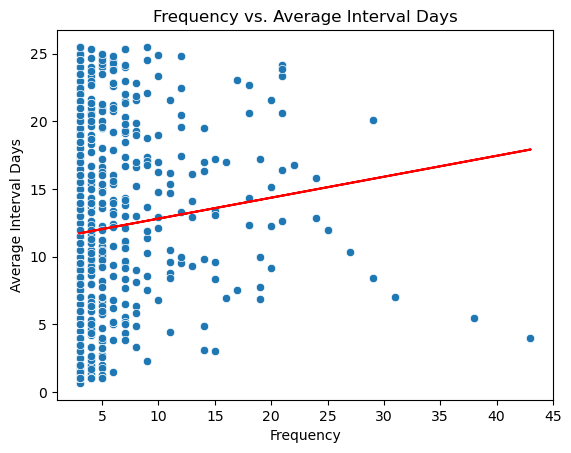

In [309]:
# Create scatter plot using seaborn
sns.scatterplot(data=engagement_df, x='frequency', y='avg_interval_days')

# Set plot title
plt.title('Frequency vs. Average Interval Days')

# Set axis labels
plt.xlabel('Frequency')
plt.ylabel('Average Interval Days')

# Calculate the trendline
slope, intercept = np.polyfit(engagement_df['frequency'], engagement_df['avg_interval_days'], 1)
trendline = slope * engagement_df['frequency'] + intercept

# Plot the trendline
plt.plot(engagement_df['frequency'], trendline, color='red')

# Show the plot
plt.show()

**Though there is a positive trendline that was fit to the data, many of the points are not close to the trendline. This suggest a weaker relationship between the variables. I want to verify that with a correlation coefficient.**

In [315]:
# engagement_df['RFMScore'].astype(int)

freq_avgint = engagement_df
#[(returning_customers_df['first_order_promo_code'].notnull()) &
#                                          (returning_customers_df['days_between_1st_2nd_order'] <= 30)
#                                         ]


correlation = freq_avgint['frequency'].corr(freq_avgint['avg_interval_days'])

correlation

0.1047357340112458

**This shows a weak positive relationship between frequency and avg_interval_days. But now I wonder if there is a stronger relationship between frequency and lifetime days. I would expect the correlation coefficient to be higher as with more lifetime days may come more orders.**

In [316]:
#What about frequency and lifetime?


correlation = freq_avgint['frequency'].corr(freq_avgint['lifetime_days'])

correlation

0.8338191245586822

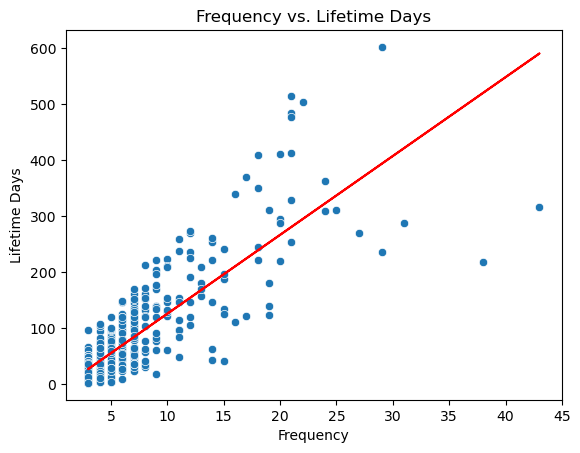

In [317]:
sns.scatterplot(data=engagement_df, x='frequency', y='lifetime_days')

# Set plot title
plt.title('Frequency vs. Lifetime Days')

# Set axis labels
plt.xlabel('Frequency')
plt.ylabel('Lifetime Days')

# Calculate the trendline
slope, intercept = np.polyfit(engagement_df['frequency'], engagement_df['lifetime_days'], 1)
trendline = slope * engagement_df['frequency'] + intercept

# Plot the trendline
plt.plot(engagement_df['frequency'], trendline, color='red')

# Show the plot
plt.show()

**The above correlation coefficient and scatterplot suggest a strong positive relationship between frequency and lifetime days. So we can update the engagement_df to filter for this subset of engaged customers.**

In [325]:
engagement_df = rfm_segmentation2[(rfm_segmentation2['f_quartile'].isin([3, 4])) & 
                                 (rfm_segmentation2['avg_interval_quartile'].isin([3, 4])) &
                                 (rfm_segmentation2['lifetime_days_quartile'].isin([3, 4])) 
                                  #&
                                  #(rfm_segmentation2['recency'].isin([3, 4])) #including this narrows down the customer to 8
                                ]

engagement_df

,customer_email,monetary_value,recency,frequency,created_at_min,created_at_max,lifetime_days,avg_interval_days,customer_ltv,fo_operator_name,fo_country,fo_state,fo_city,fo_space_name,first_order_date,first_order_promo_code,first_order_price_usd,first_order_discount,fo_booking_product_type,fo_quantity,so_operator_name,so_country,so_state,so_city,so_space_name,second_order_date,second_order_promo_code,so_final_price_usd,second_order_discount,so_booking_product_type,so_quantity,days_between_1st_2nd_order,today,days_from_fo,r_quartile,avg_interval_quartile,f_quartile,m_quartile,lifetime_days_quartile,customer_ltv_quartile,RFMScore
12,2014mcuesta@gmail.com,735.00,39,21,2022-02-09,2023-06-08,484,24.200000,15435.00,The Yard,US,NY,New York,The Yard Day Pass,2022-02-09,,35.00,0.00,entire_location,1.0,The Yard,US,NY,New York,The Yard Day Pass,2022-02-24,None,35.00,0.00,entire_location,1.0,15.0,2023-07-18,524,4,3,4,4,4,4,434444
103,Alexmoisesariel@gmail.com,2019.93,11,10,2023-02-10,2023-07-06,146,16.222222,20199.30,WeWork Israel,IL,None,Tel Aviv,Classroom 2M,2023-02-10,,191.95,0.00,meeting_room,1.0,WeWork Israel,IL,None,Tel Aviv,Meeting Room 16A,2023-02-19,None,158.13,0.00,meeting_room,1.0,9.0,2023-07-18,158,4,3,4,4,3,4,434434
417,Christina@parallelprojects.co,950.00,175,4,2022-11-28,2023-01-23,56,18.666667,3800.00,The Malin,US,NY,New York,The Malin Day Pass,2022-11-28,None,350.00,0.00,access_add_on,1.0,The Malin,US,NY,New York,The Malin Day Pass,2022-12-19,None,200.00,0.00,access_add_on,1.0,21.0,2023-07-18,232,3,3,3,4,3,4,334334
626,Elad@evo-it.co.il,398.16,292,8,2022-04-30,2022-09-28,151,21.571429,3185.28,WeWork Israel,IL,None,Tel Aviv,Open Workspace Day Pass,2022-04-30,WeWorkTLV,44.64,6.73,entire_location,1.0,WeWork Israel,IL,None,Tel Aviv,Open Workspace Day Pass,2022-07-19,WeWorkTLV,43.39,6.54,entire_location,1.0,80.0,2023-07-18,444,2,3,4,4,4,4,234444
1058,Joe@dowconsultinggroup.com,891.25,496,9,2021-10-20,2022-03-08,139,17.375000,8021.25,Mindspace,US,PA,Philadelphia,Mindspace Daily - Wanamaker,2021-10-20,SPECIAL521,90.00,0.00,entire_location,3.0,Mindspace,US,PA,Philadelphia,Mindspace Daily - Wanamaker,2021-10-21,None,90.00,0.00,entire_location,3.0,1.0,2023-07-18,636,1,3,4,4,3,4,134434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14417,yuval@four.place,1385.74,27,12,2023-02-20,2023-06-20,120,10.000000,16628.88,WeWork Israel,IL,None,Tel Aviv,Open Workspace Day Pass,2023-02-20,AZRIELI50,177.38,0.00,access_add_on,1.0,WeWork Israel,IL,None,Tel Aviv,Open Workspace Day Pass,2023-02-27,AZRIELI50,218.94,187.13,access_add_on,1.0,7.0,2023-07-18,148,4,3,4,4,3,4,434434
14450,zahar.chikishev@gmail.com,526.76,307,8,2022-07-12,2022-09-13,63,9.000000,4214.08,WeWork Israel,IL,None,Haifa,Daily Office - 4p with window,2022-07-12,None,162.54,0.00,private_office,1.0,WeWork Israel,IL,None,Haifa,Open Workspace Day Pass,2022-08-01,None,31.15,0.00,entire_location,1.0,20.0,2023-07-18,371,2,3,4,4,3,4,234434
14451,zahar@wize-b.com,150.60,257,5,2022-09-07,2022-11-02,56,14.000000,753.00,WeWork Israel,IL,None,Haifa,Open Workspace Day Pass,2022-09-07,None,30.71,0.00,entire_location,1.0,WeWork Israel,IL,None,Haifa,Open Workspace Day Pass,2022-09-20,None,30.59,0.00,entire_location,1.0,13.0,2023-07-18,314,2,3,4,2,3,3,232433
14480,zharovanastasiia@gmail.com,238.65,355,5,2022-04-18,2022-07-27,100,25.000000,1193.25,WeWork Israel,IL,None,Tel Aviv,Open Workspace Day Pass,2022-04-18,WeWorkTLV,54.21,0.00,entire_location,1.0,WeWork Israel,IL,None,Tel Aviv,Open Workspace Day Pass,2022-05-02,None,52.48,0.00,entire_location,1.0,14.0,2023-07-18,456,2,3,4,3,3,3,233433


In [321]:
return_rfm_quantiles

,monetary_value,recency,frequency,lifetime_days,avg_interval_days,customer_ltv
0.25,90.00,81.00,2.0,9.25,7.0,192.0000
0.50,178.65,215.00,2.0,50.00,25.5,463.8150
0.75,398.06,389.75,4.0,147.00,62.0,1315.8225


In [322]:
engagement_df.describe()

,monetary_value,recency,frequency,lifetime_days,avg_interval_days,customer_ltv,first_order_price_usd,first_order_discount,fo_quantity,so_final_price_usd,second_order_discount,so_quantity,days_between_1st_2nd_order,days_from_fo,r_quartile,avg_interval_quartile,f_quartile,m_quartile,lifetime_days_quartile,customer_ltv_quartile
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,1252.915160,184.926941,9.365297,139.648402,16.872461,19195.337215,123.130091,6.822283,1.264840,114.690183,5.217306,1.232877,18.219178,325.575342,2.899543,3.045662,3.831050,3.621005,3.296804,3.840183
std,2010.784509,187.978391,6.461877,98.414307,5.579248,68926.461804,169.053554,38.078215,0.762177,146.240071,26.074542,0.694418,17.968050,189.956218,1.148972,0.209229,0.375566,0.633700,0.457896,0.379560
min,98.560000,0.000000,3.000000,51.000000,4.000000,295.680000,20.000000,0.000000,1.000000,20.000000,0.000000,1.000000,1.000000,63.000000,1.000000,3.000000,3.000000,2.000000,3.000000,2.000000
25%,338.015000,25.000000,5.000000,70.500000,12.525000,1935.000000,35.000000,0.000000,1.000000,35.000000,0.000000,1.000000,5.000000,174.000000,2.000000,3.000000,4.000000,3.000000,3.000000,4.000000
50%,630.000000,117.000000,7.000000,108.000000,17.222222,4290.000000,54.490000,0.000000,1.000000,61.480000,0.000000,1.000000,11.000000,287.000000,3.000000,3.000000,4.000000,4.000000,3.000000,4.000000
75%,1232.425000,292.000000,11.000000,165.000000,21.333333,14539.615000,136.890000,0.000000,1.000000,137.245000,0.000000,1.000000,27.000000,462.500000,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000
max,21734.280000,740.000000,43.000000,602.000000,25.500000,934574.040000,1292.000000,323.000000,6.000000,1221.570000,261.520000,6.000000,101.000000,848.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


**This final subset of engaged customers are those that fall into the 3rd and 4th quartiles for frequency, avg interval days, and lifetime days. I want to see what features these customers have that may correlate to engagement.**

**2. Which users are providing more business and why?**

I want investigate the monetary_value column to identify customers who have made higher-value purchases. Analyze the factors that contribute to their higher spending, such as specific product types, promotion codes, or discounts.
- Pull 4th quartile monetary_values to see why they are spending
- Did they spend more on second order?

General - compare with one-timers, use findings from returning customers to make recommendations

#### Returning Customer Re-Order Rate

I want to compare the rate between the returning customers who got discount on first order, and those who did not get discount on first order
- Did they reorder within 30 days of customer's first order (excluding all customers who are not 30 days old)
- number of people who re-ordered within 30 days / total number people did or did not get a discount

In [211]:
returning_customers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3058 entries, 0 to 14517
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_email              3058 non-null   object 
 1   monetary_value              3058 non-null   float64
 2   recency                     3058 non-null   int64  
 3   frequency                   3058 non-null   int64  
 4   created_at_min              3058 non-null   object 
 5   created_at_max              3058 non-null   object 
 6   lifetime_days               3058 non-null   int64  
 7   avg_interval_days           3058 non-null   float64
 8   customer_ltv                3058 non-null   float64
 9   r_quartile                  3058 non-null   int64  
 10  avg_interval_quartile       3058 non-null   int64  
 11  f_quartile                  3058 non-null   int64  
 12  m_quartile                  3058 non-null   int64  
 13  lifetime_days_quartile      3058

In [214]:
# Reorder with discount within 30 days, excluding customers who are not at least 30 lifetime days 

return_discount = returning_customers_df[(returning_customers_df['first_order_discount'] > 0) &
                                         #(returning_customers_df['lifetime_days'] >= 30) &
                                         (returning_customers_df['days_between_1st_2nd_order'] <= 30)
                                        ].shape[0]

#Reorder without discount within 30 days
return_no_discount = returning_customers_df[(returning_customers_df['first_order_discount'] == 0) &
                                         (returning_customers_df['days_between_1st_2nd_order'] <= 30)
                                        ].shape[0]


#Reorder rate with discount within 30 days
reorder_rate_discount = return_discount / (return_discount + return_no_discount)


#Reorder rate without discount within 30 days
reorder_rate_no_discount = return_no_discount / (return_discount + return_no_discount)


print(f'Number of customers who returned with a first order discount: {return_discount}')
print(f'Number of customers who returned without a first order discount: {return_no_discount}')
print(f'The re-order rate for customers who received first order discounts: {reorder_rate_discount}')
print(f'Re-order rate for customers who did not receive first order discount: {reorder_rate_no_discount}')

Number of customers who returned with a first order discount: 143
Number of customers who returned without a first order discount: 1734
The re-order rate for customers who received first order discounts: 0.0761854022376132
Re-order rate for customers who did not receive first order discount: 0.9238145977623868


**There is a higher re-order rate within 30 days for returning customers who did not receive a discount. But I want to see what else may be contributing to why customers returned.**

- 7.6% of customers who re-ordered within 30 days had a discount on their first order
- 92.4% of customers who re-ordered within 30 days did not have a discount on their first order


#### Promotion Code Re-Order Rate

What about returning customers who received a promotion code on their first order? Will this result look the same as the re-order rate for those who got a discount? (re-order within 30 days)

In [220]:
returning_customers_df.first_order_promo_code.count()

1322

In [225]:
#I want to make sure there were no varying none, or NA values in the promo code column

# is_none_present = 'n/a' in first_order_df['first_order_promo_code'].str.lower().values

# is_none_present

In [226]:
return_promo = returning_customers_df[(returning_customers_df['first_order_promo_code'].notnull()) &
                                         #(returning_customers_df['lifetime_days'] >= 30) &
                                         (returning_customers_df['days_between_1st_2nd_order'] <= 30)
                                        ].shape[0]

#Reorder without discount within 30 days
return_no_promo = returning_customers_df[(returning_customers_df['first_order_promo_code'].isnull()) &
                                         (returning_customers_df['days_between_1st_2nd_order'] <= 30)
                                        ].shape[0]


#Reorder rate with discount within 30 days
reorder_rate_promo = return_promo / (return_promo + return_no_promo)


#Reorder rate without discount within 30 days
reorder_rate_no_promo = return_no_promo / (return_promo + return_no_promo)


print(f'Number of customers who returned with a first order promo: {return_promo}')
print(f'Number of customers who returned without a first order promo: {return_no_promo}')
print(f'The re-order rate for customers who received first order promo: {reorder_rate_promo}')
print(f'Re-order rate for customers who did not receive first order promo: {reorder_rate_no_promo}')

Number of customers who returned with a first order promo: 731
Number of customers who returned without a first order promo: 1146
The re-order rate for customers who received first order promo: 0.38945125199786895
Re-order rate for customers who did not receive first order promo: 0.6105487480021311


**There is a higher re-order rate within 30 days for returning customers who did not receive a promotion, but the reorder rate for first order promotions is much higher than the re-order rate of those who got a discount.**

- 38.9% of customers who re-ordered within 30 days had a promo on their first order
- 61.1% of customers who re-ordered within 30 days did not have a promo on their first order


In [ ]:
#Tableau
#accumulated customers over time

**Correlation between RFMScore and Promo Code**

I want to see if there is a correlation between these metrics to understand if this feature was something that brought customers back.

In [233]:
returning_customers_df['RFMScore'].astype(int)

return_promo2 = returning_customers_df[#(returning_customers_df['first_order_promo_code'].notnull()) &
                                         (returning_customers_df['days_between_1st_2nd_order'] <= 30)
                                        ]


correlation = return_promo2['RFMScore'].corr(return_promo2['first_order_promo_code'].notnull().astype(int))

correlation

0.4137668059798768

**General interpretation of the correlation coefficient:**

The value of 0.41 suggests a moderate positive correlation. It indicates that there is a tendency for customers with higher RFM scores to have a higher likelihood of having a promotion code on their first order.

The positive sign (+) indicates that as the RFM score increases, the presence of a promotion code on the first order tends to increase as well.

It's important to keep in mind that correlation does not imply causation. A positive correlation does not necessarily mean that having a promotion code directly causes higher RFM scores or vice versa. Other factors or variables may be influencing the relationship.

**Correlation between Promo Code and Days between Orders**

I want to see whether there is a relationship between first order promo code and days between first and second order

In [267]:
return_promo = returning_customers_df[#(returning_customers_df['first_order_promo_code'].notnull()) &
                                         (returning_customers_df['days_between_1st_2nd_order'] <= 30)
                                        ]


correlation1 = returning_customers_df['days_between_1st_2nd_order'].corr(returning_customers_df['first_order_promo_code'].notnull().astype(int))

correlation_within_30_days = return_promo2['days_between_1st_2nd_order'].corr(return_promo2['first_order_promo_code'].notnull().astype(int))


print(correlation1)
print(correlation2)

0.08086573563451911
0.15866258501265962


**Whether looking at returning customers who placed a second order at any time, or returning customer who placed a second order within 30 days, the correlation coefficients are both positve, but show weak relationships**

#### Other features that may be correlated to returning customers

In [234]:
#What other features are in the returning customers df?

returning_customers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3058 entries, 0 to 14517
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_email              3058 non-null   object 
 1   monetary_value              3058 non-null   float64
 2   recency                     3058 non-null   int64  
 3   frequency                   3058 non-null   int64  
 4   created_at_min              3058 non-null   object 
 5   created_at_max              3058 non-null   object 
 6   lifetime_days               3058 non-null   int64  
 7   avg_interval_days           3058 non-null   float64
 8   customer_ltv                3058 non-null   float64
 9   r_quartile                  3058 non-null   int64  
 10  avg_interval_quartile       3058 non-null   int64  
 11  f_quartile                  3058 non-null   int64  
 12  m_quartile                  3058 non-null   int64  
 13  lifetime_days_quartile      3058

**Where are the returning customers located?**

In [266]:
country_mapping = {'US': 'United States', 
                   'GB': 'United Kingdom', 
                   'IL': 'Israel', 
                   'NL': 'Netherlands', 
                   'PL':'Poland', 
                   'RO':'Romania',
                   'DE':'Germany'
                  }

# Create a new column with the full country names
returning_customers_df['so_country_full'] = returning_customers_df['so_country'].map(country_mapping)

returning_customers_country = returning_customers_df.groupby('so_country_full')['customer_email'].count().reset_index()


returning_customers_country = returning_customers_country.sort_values('customer_email', ascending=False, ignore_index=True)

returning_customers_country

C:\Users\nguzm\AppData\Local\Temp\ipykernel_12268\2500961947.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returning_customers_df['so_country_full'] = returning_customers_df['so_country'].map(country_mapping)


,so_country_full,customer_email
0,United States,1128
1,Israel,795
2,Germany,723
3,United Kingdom,172
4,Netherlands,109
5,Poland,78
6,Romania,52


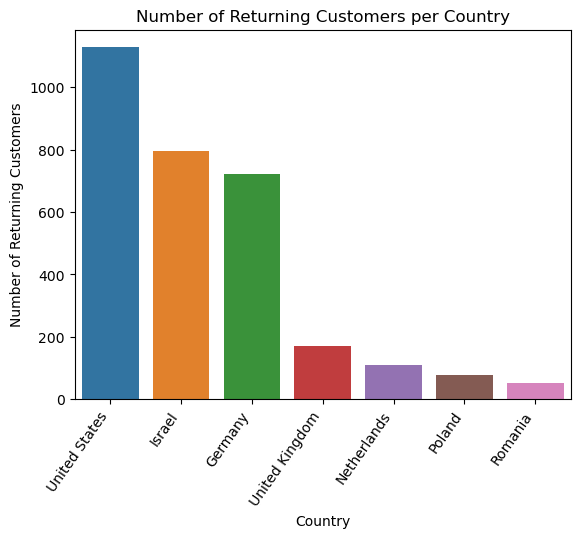

In [255]:
sns.barplot(data = returning_customers_country, x = 'so_country_full', y = 'customer_email').set(title='Number of Returning Customers per Country', xlabel='Country', ylabel='Number of Returning Customers')
plt.xticks(rotation = 55, ha='right')
plt.show;